# Analytics - Product Quality

#### Date: 2024/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Sentinela

##### Semester: 2024/2
##### Professor: Hilmer Neri

##### Members:

- Clara Ribeiro
- Daniela Soares
- Guilherme Peixoto
- Dannyeclisson Rodrigo
- Eduardo Levenhagem
- Guilherme Moura
- Ígor Veras
- João Igor
- Jorge Henrique
- Mariana Martins
- Rodrigo Amaral
- Yzabella Pimenta


## Resultados das Análises

### Microsserviço de backend com o pior indicador de manutenibilidade: Financeiro

As métricas de manutenebilidade analisadas são: complexidade, linhas comentadas e linhas duplicadas.

- Média: 0.266538
- Modo: 0.266538
- Mediana: 0.266538

![Gráfico de Manutenebilidade e Confiabilidade](images/financeiro-manutenebilidade-status.png)

Ao ver a análise do Sonarcloud a respeito de manutenebilidade, conseguimos visualizar os arquivos com maiores pontos críticos, sendo eles:

- src/Controllers/financialMovementsController.js
- src/Models/csvGenerator.js
- src/Controllers/financialReportController.js

![Arquivos com code smells de manutenebilidade](images/maintainability-overview-1.png)
![Arquivos com code smells de manutenebilidade](images/maintainability-overview-2.png)
![Arquivos com code smells de manutenebilidade](images/maintainability-overview-3.png)

Pela análise dos arquivos, os índices de linhas comentadas e linhas duplicadas são o que mais estão impactando o indicador de manutenebilidade. Entendemos que a refatoração desses code smells são feitos com facilidade e já criamos uma atividade no shortcut para tal ação, que pode ser acessada por esse [link](https://app.zenhub.com/workspaces/20242-sentinela-671a73b04c2c44000f895e1e/issues/gh/fga-eps-mds/2024.2-sentinela-doc/151).

![Exemplo de code smell](images/maintainability-overview-4.png)

### Microsserviço com o pior indicador de confiabilidade: Benefícios

- Média: 0.392857
- Modo: 0.392857
- Mediana: 0.392857

![Gráfico de Manutenebilidade e Confiabilidade](images/beneficios-confiabilidade-status.png)

O principal problema de confiabilidade é da parte de testes de software. Para ajudar a resolver esse problema, estamos trabalhando constantemente para aumentar a cobertura e ajustar os testes que estão falhando.

![Exemplo de code smell](images/reliability-overview.png)


### LIBRARIES

In [190]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

import re


### GRAPH SETTINGS

In [191]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [192]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [193]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2024.2-SENTINELA_'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'BENEFICIOS': 'js',
    'FINANCEIRO': 'js',
    'USUARIOS': 'js',
    'FRONT': 'js',
}

### SonarCloud
##### Path to the folder with all your jsons

In [194]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/fga-eps-mds-*.json')

## Create DataFrame

#### Unmarshall json

In [195]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [196]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [197]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [198]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [199]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [200]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def replace_hyphen_to_underscore(text: str) -> str:
    # Define a pattern to match the target format (e.g., SENTINELA-BACKEND-USUARIOS)
    pattern = r'([A-Z]+(?:-[A-Z]+)+)'

    def replace_func(match):
        # Replace hyphens with underscores in the matched text
        return match.group(0).replace('-', '_')

    # Perform the substitution
    result = re.sub(pattern, replace_func, text)
    return result



def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)
        # print(base_name)
        print(replace_hyphen_to_underscore(base_name).split("-")[4].split("_")[-1], replace_hyphen_to_underscore(base_name))
        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[replace_hyphen_to_underscore(base_name).split("-")[4].split("_")[-1]])



        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [201]:
print(sonar_files)
repos_language


['../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS-01-19-2025-18-40-08-1.0.1.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS-01-31-2025-00-21-20-1.0.2.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-FINANCEIRO-01-19-2025-19-00-31-1.0.1.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-FINANCEIRO-01-26-2025-23-54-39-1.0.2.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-FINANCEIRO-01-30-2025-23-43-55-1.0.3.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-FINANCEIRO-01-30-2025-23-52-34-1.0.4.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-USUARIOS-01-19-2025-18-49-03-1.0.1.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-USUARIOS-01-26-2025-21-39-30-1.0.2.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND-USUARIOS-01-27-2025-20-21-48-1.0.3.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA-BACKEND

{'BENEFICIOS': 'js', 'FINANCEIRO': 'js', 'USUARIOS': 'js', 'FRONT': 'js'}

In [202]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-01-19-2025-18-40-08-1.0.1.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-01-31-2025-00-21-20-1.0.2.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-01-19-2025-19-00-31-1.0.1.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-01-26-2025-23-54-39-1.0.2.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-01-30-2025-23-43-55-1.0.3.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-01-30-2025-23-52-34-1.0.4.json
USUARIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS-01-19-2025-18-49-03-1.0.1.json
USUARIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS-01-26-2025-21-39-30-1.0.2.json
USUARIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS-01-27-2025-20-21-48-1.0.3.json
USUARIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS-01-27-2025-22-55-12-1.0.4.json
USUARIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS-01-28-2025-01-18-31-1.0.5.json
USUARIOS fga-eps-mds-2024.2-SE

array(['fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS',
       'fga-eps-mds-2024.2-SENTINELA-BACKEND-FINANCEIRO',
       'fga-eps-mds-2024.2-SENTINELA-BACKEND-USUARIOS',
       'fga-eps-mds-2024.2-SENTINELA-FRONT',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS',
       'fga-eps-mds-2024.2-SENTINELA_FRONT'], dtype=object)

### Create dataframe per repository

In [203]:
file_component_df['repository']

0       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
1       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
2       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
3       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
4       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
5       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
6       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
7       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
8       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
9       fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
10      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
11      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
12      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
13      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
14      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
15      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
16      fga-eps-mds-2024.2-SENTINELA-BACKEND-BENEFICIOS
17      fga-eps-mds-2024.2-SENTINELA-BACKEND-BEN

In [204]:
repos_dataframes = []

for repo in repos_language.keys():
    if repo=="FRONT": 
        name = repo_name+repo
    else:
        name = repo_name+"BACKEND_"+repo
    dataframe = file_component_df[file_component_df['repository'] == name]
    repos_dataframes.append({'name': repo, 'df': dataframe})

In [205]:
repos_dataframes
for repo in repos_language.keys():
  if repo=="FRONT": 
    print(repo_name+repo)
  else:
    print(repo_name+"BACKEND_"+repo)


fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS
fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO
fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS
fga-eps-mds-2024.2-SENTINELA_FRONT


## Measure calculations according to Q-Rapids quality model

In [206]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [207]:
def complexity(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [208]:
def comments(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [209]:
def duplication(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [210]:
def test_success(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [211]:
def fast_tests(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [212]:
def coverage(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [213]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(complexity(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(comments(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(duplication(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(test_success(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(fast_tests(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(coverage(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'complexity': m1_list,
        'comments': m2_list,
        'duplication': m3_list,
        'test_success': m4_list,
        'fast_tests': m5_list,
        'coverage': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [214]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

C:\Users\Usuário\AppData\Local\Temp\ipykernel_2800\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
C:\Users\Usuário\AppData\Local\Temp\ipykernel_2800\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
C:\Users\Usuário\AppData\Local\Temp\ipykernel_2800\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

In [215]:
display(metrics)

{'BENEFICIOS':    complexity  comments  duplication  test_success  fast_tests  coverage  \
 0    0.571429  0.285714          1.0           1.0         1.0  0.714286   
 1    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 2    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 3    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 4    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 5    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 6    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 7    0.571429  0.285714          1.0           1.0         1.0  0.571429   
 
                                         repository              version  ncloc  
 0  fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS    1-16-2025-2-42-51    742  
 1  fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS  12-13-2024-13-54-25    742  
 2  fga-eps-mds-2024.2-SENTINELA_BACKEND_BENE

## Data visualization

In this area you will need to plot the metrics of each repository.

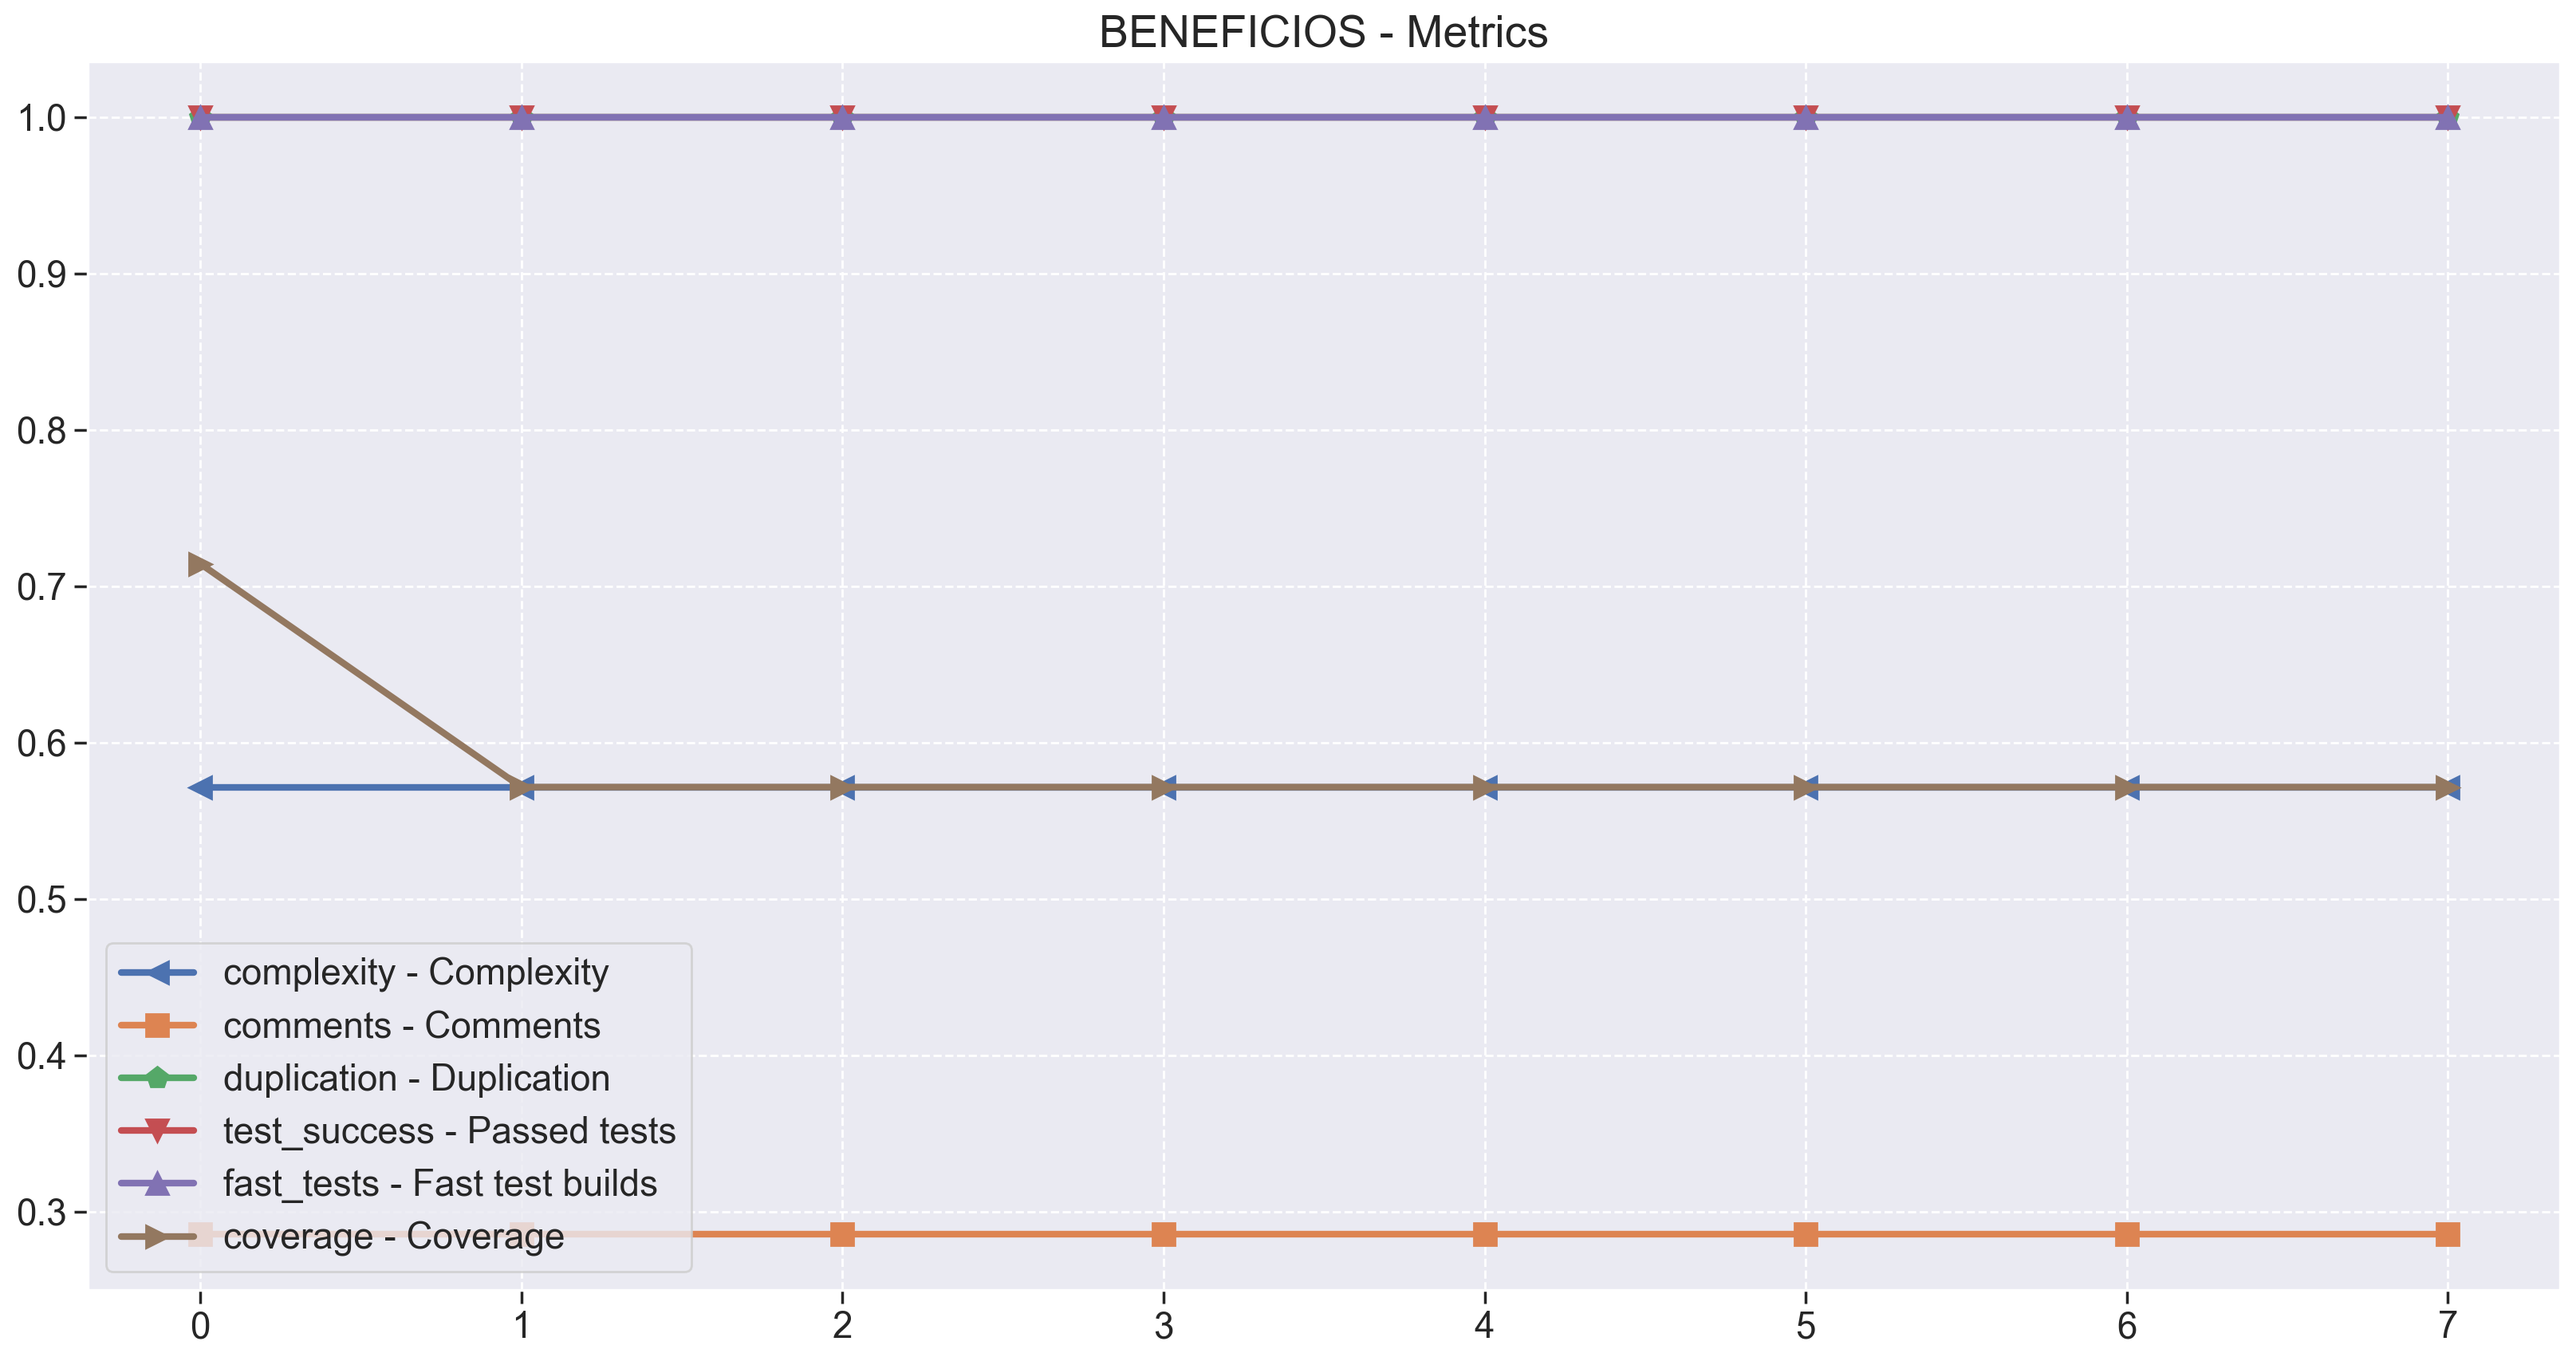

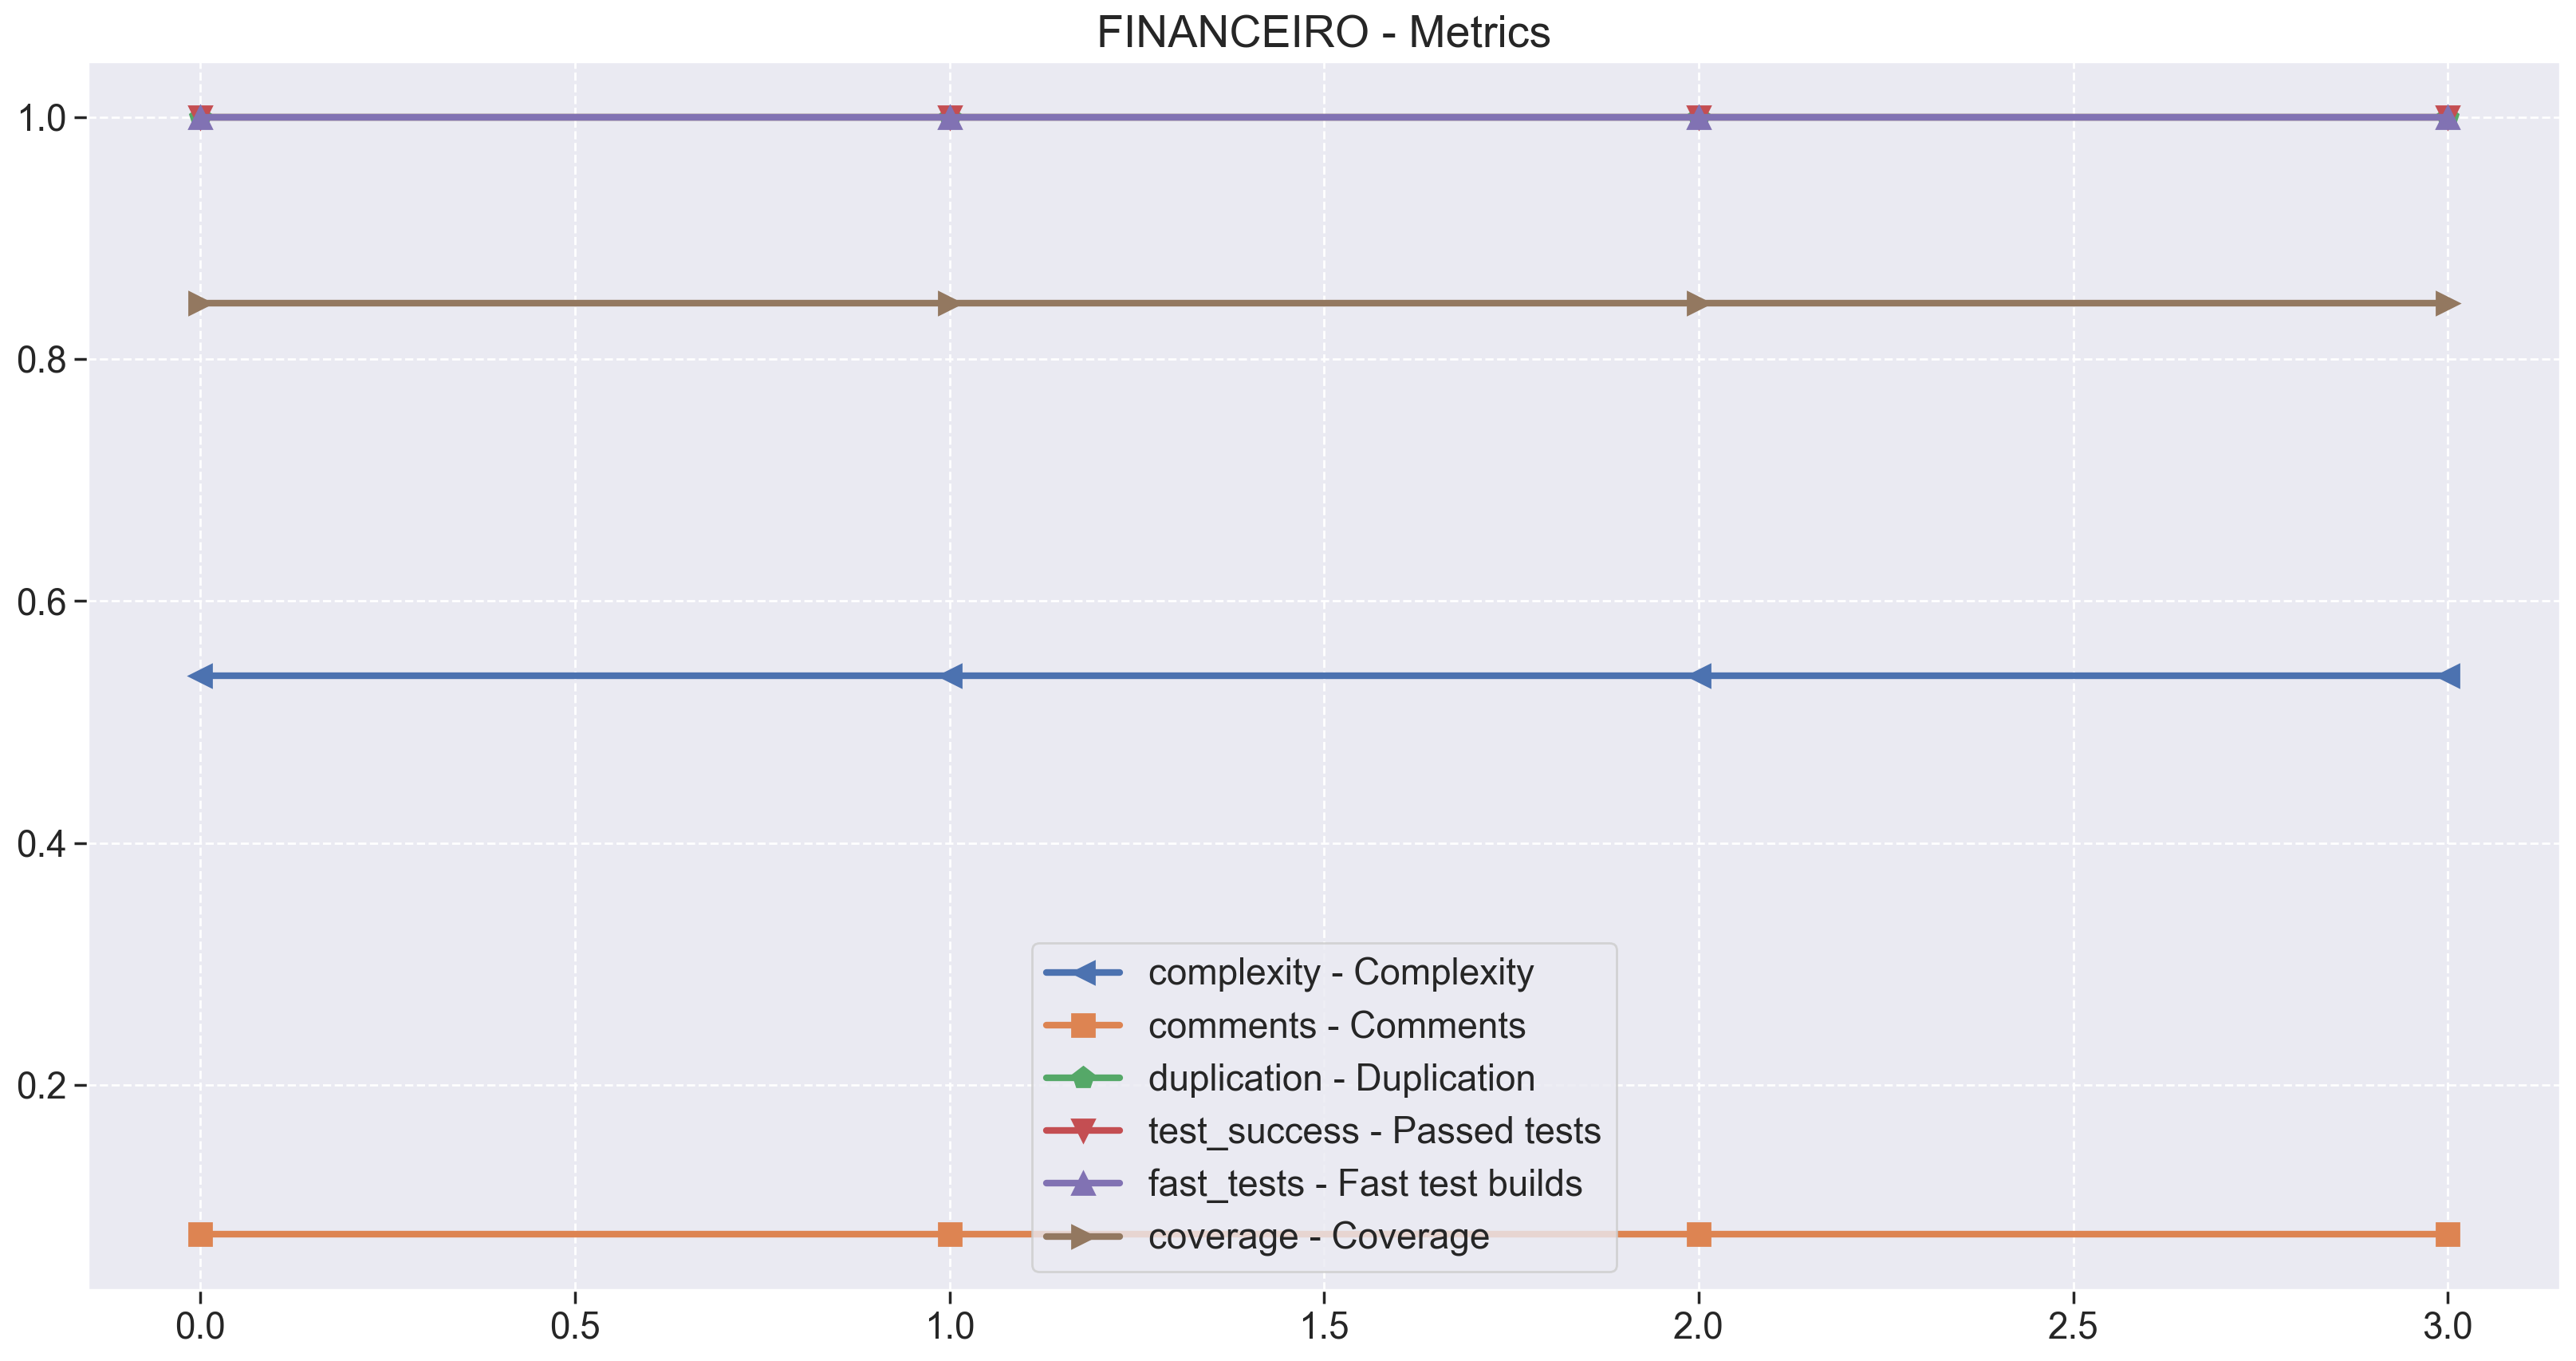

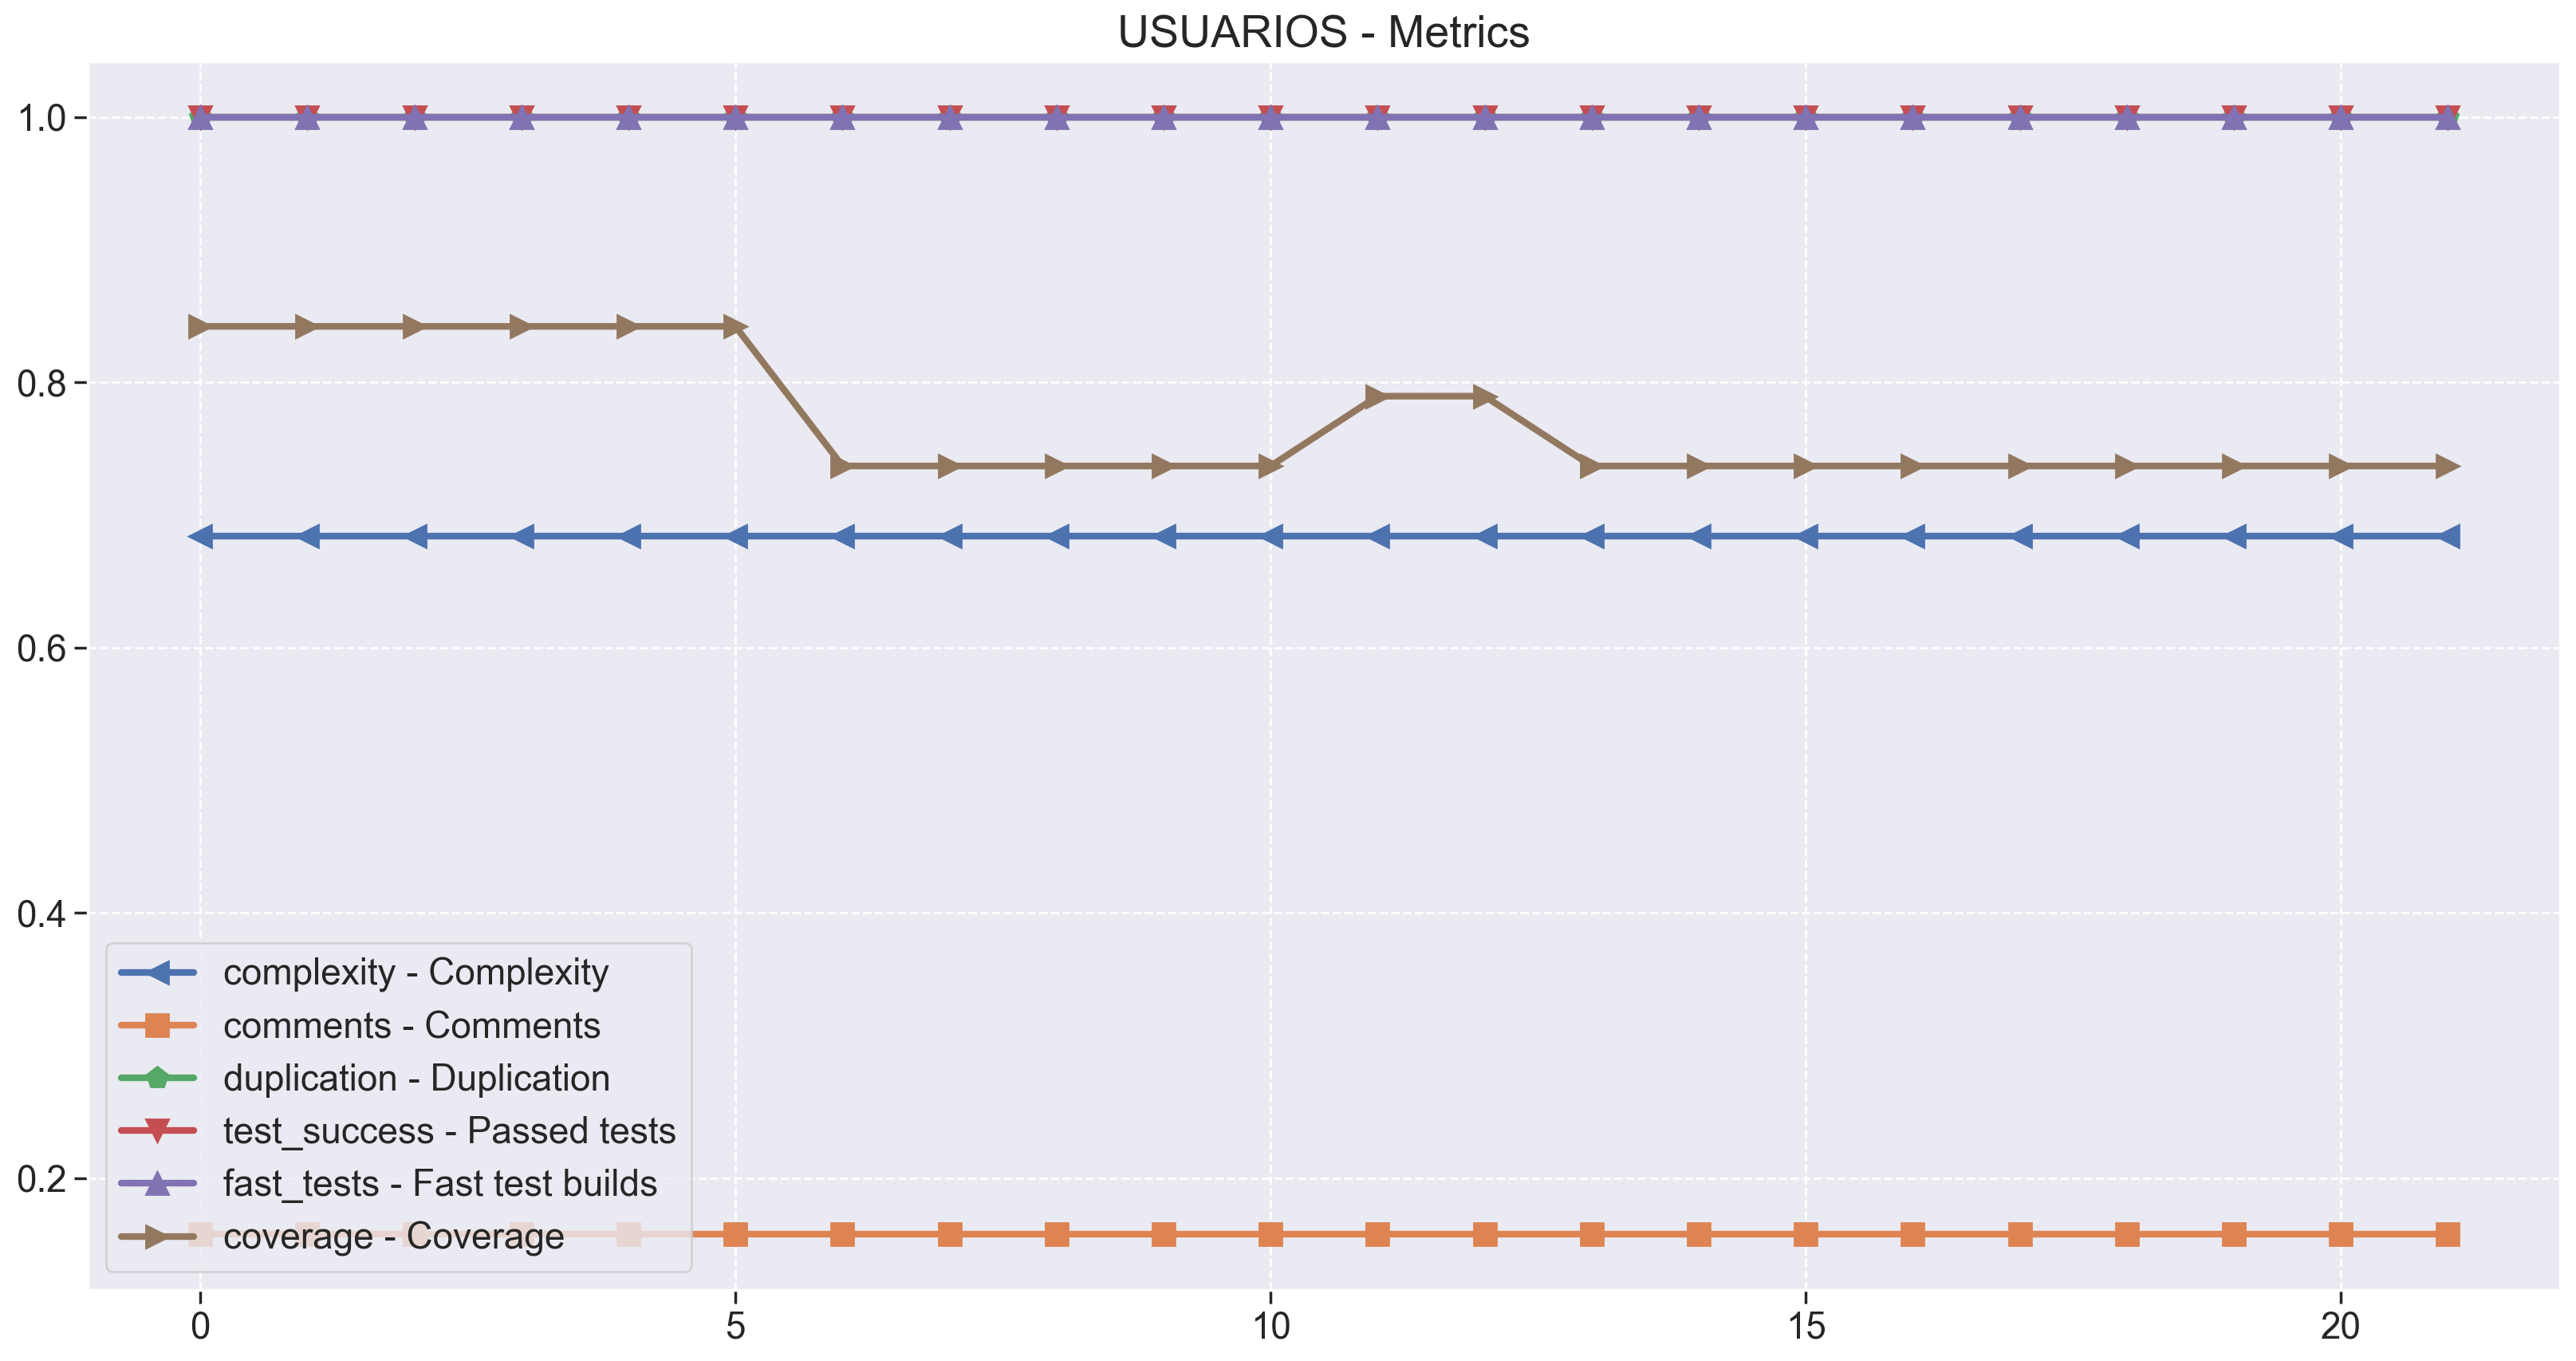

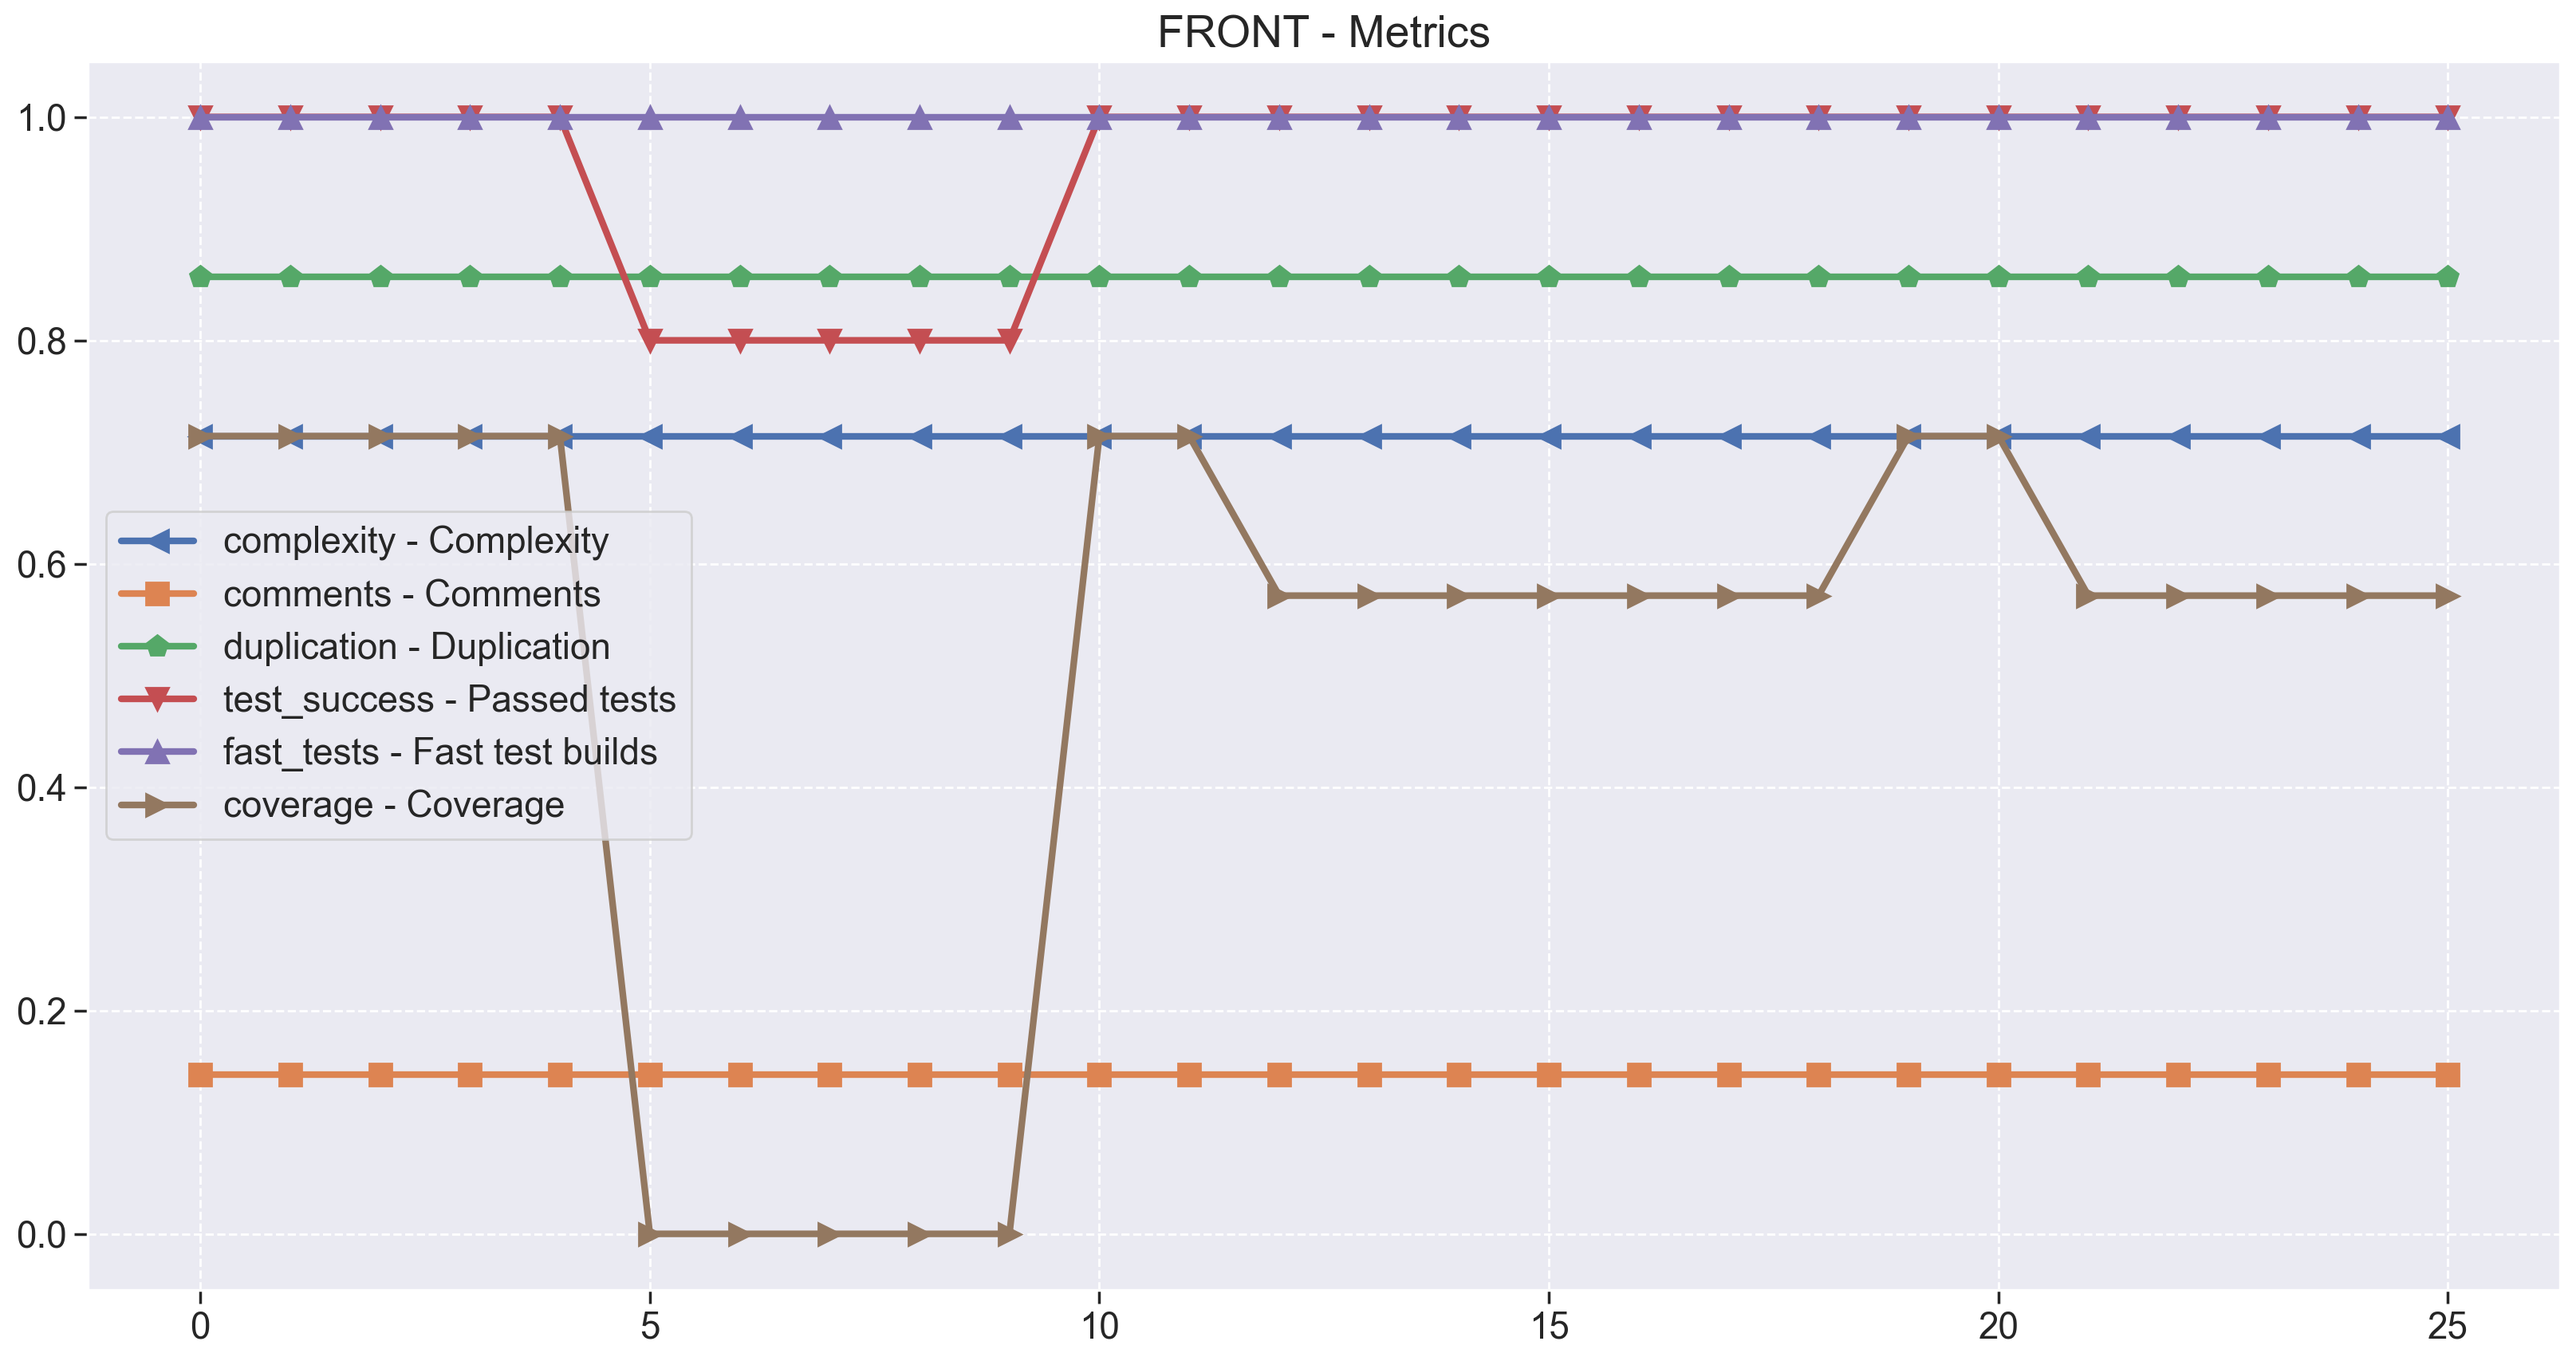

In [216]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['complexity'], linewidth=3, marker='<', markersize=10, label="complexity - Complexity")
    plt.plot(data['comments'], linewidth=3, marker='s', markersize=10, label="comments - Comments")
    plt.plot(data['duplication'], linewidth=3, marker='p', markersize=10, label="duplication - Duplication")
    plt.plot(data['test_success'], linewidth=3, marker='v', markersize=10, label="test_success - Passed tests")
    plt.plot(data['fast_tests'], linewidth=3, marker='^', markersize=10, label="fast_tests - Fast test builds")
    plt.plot(data['coverage'], linewidth=3, marker='>', markersize=10, label="coverage - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [217]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['complexity']*pm1) + (data['comments']*pm2) + (data['duplication']*pm3)) * psc1
    data['testing_status'] = ((data['test_success']*pm4) + (data['fast_tests']*pm5) + (data['coverage']*pm6)) * psc2

### Code Quality visualization

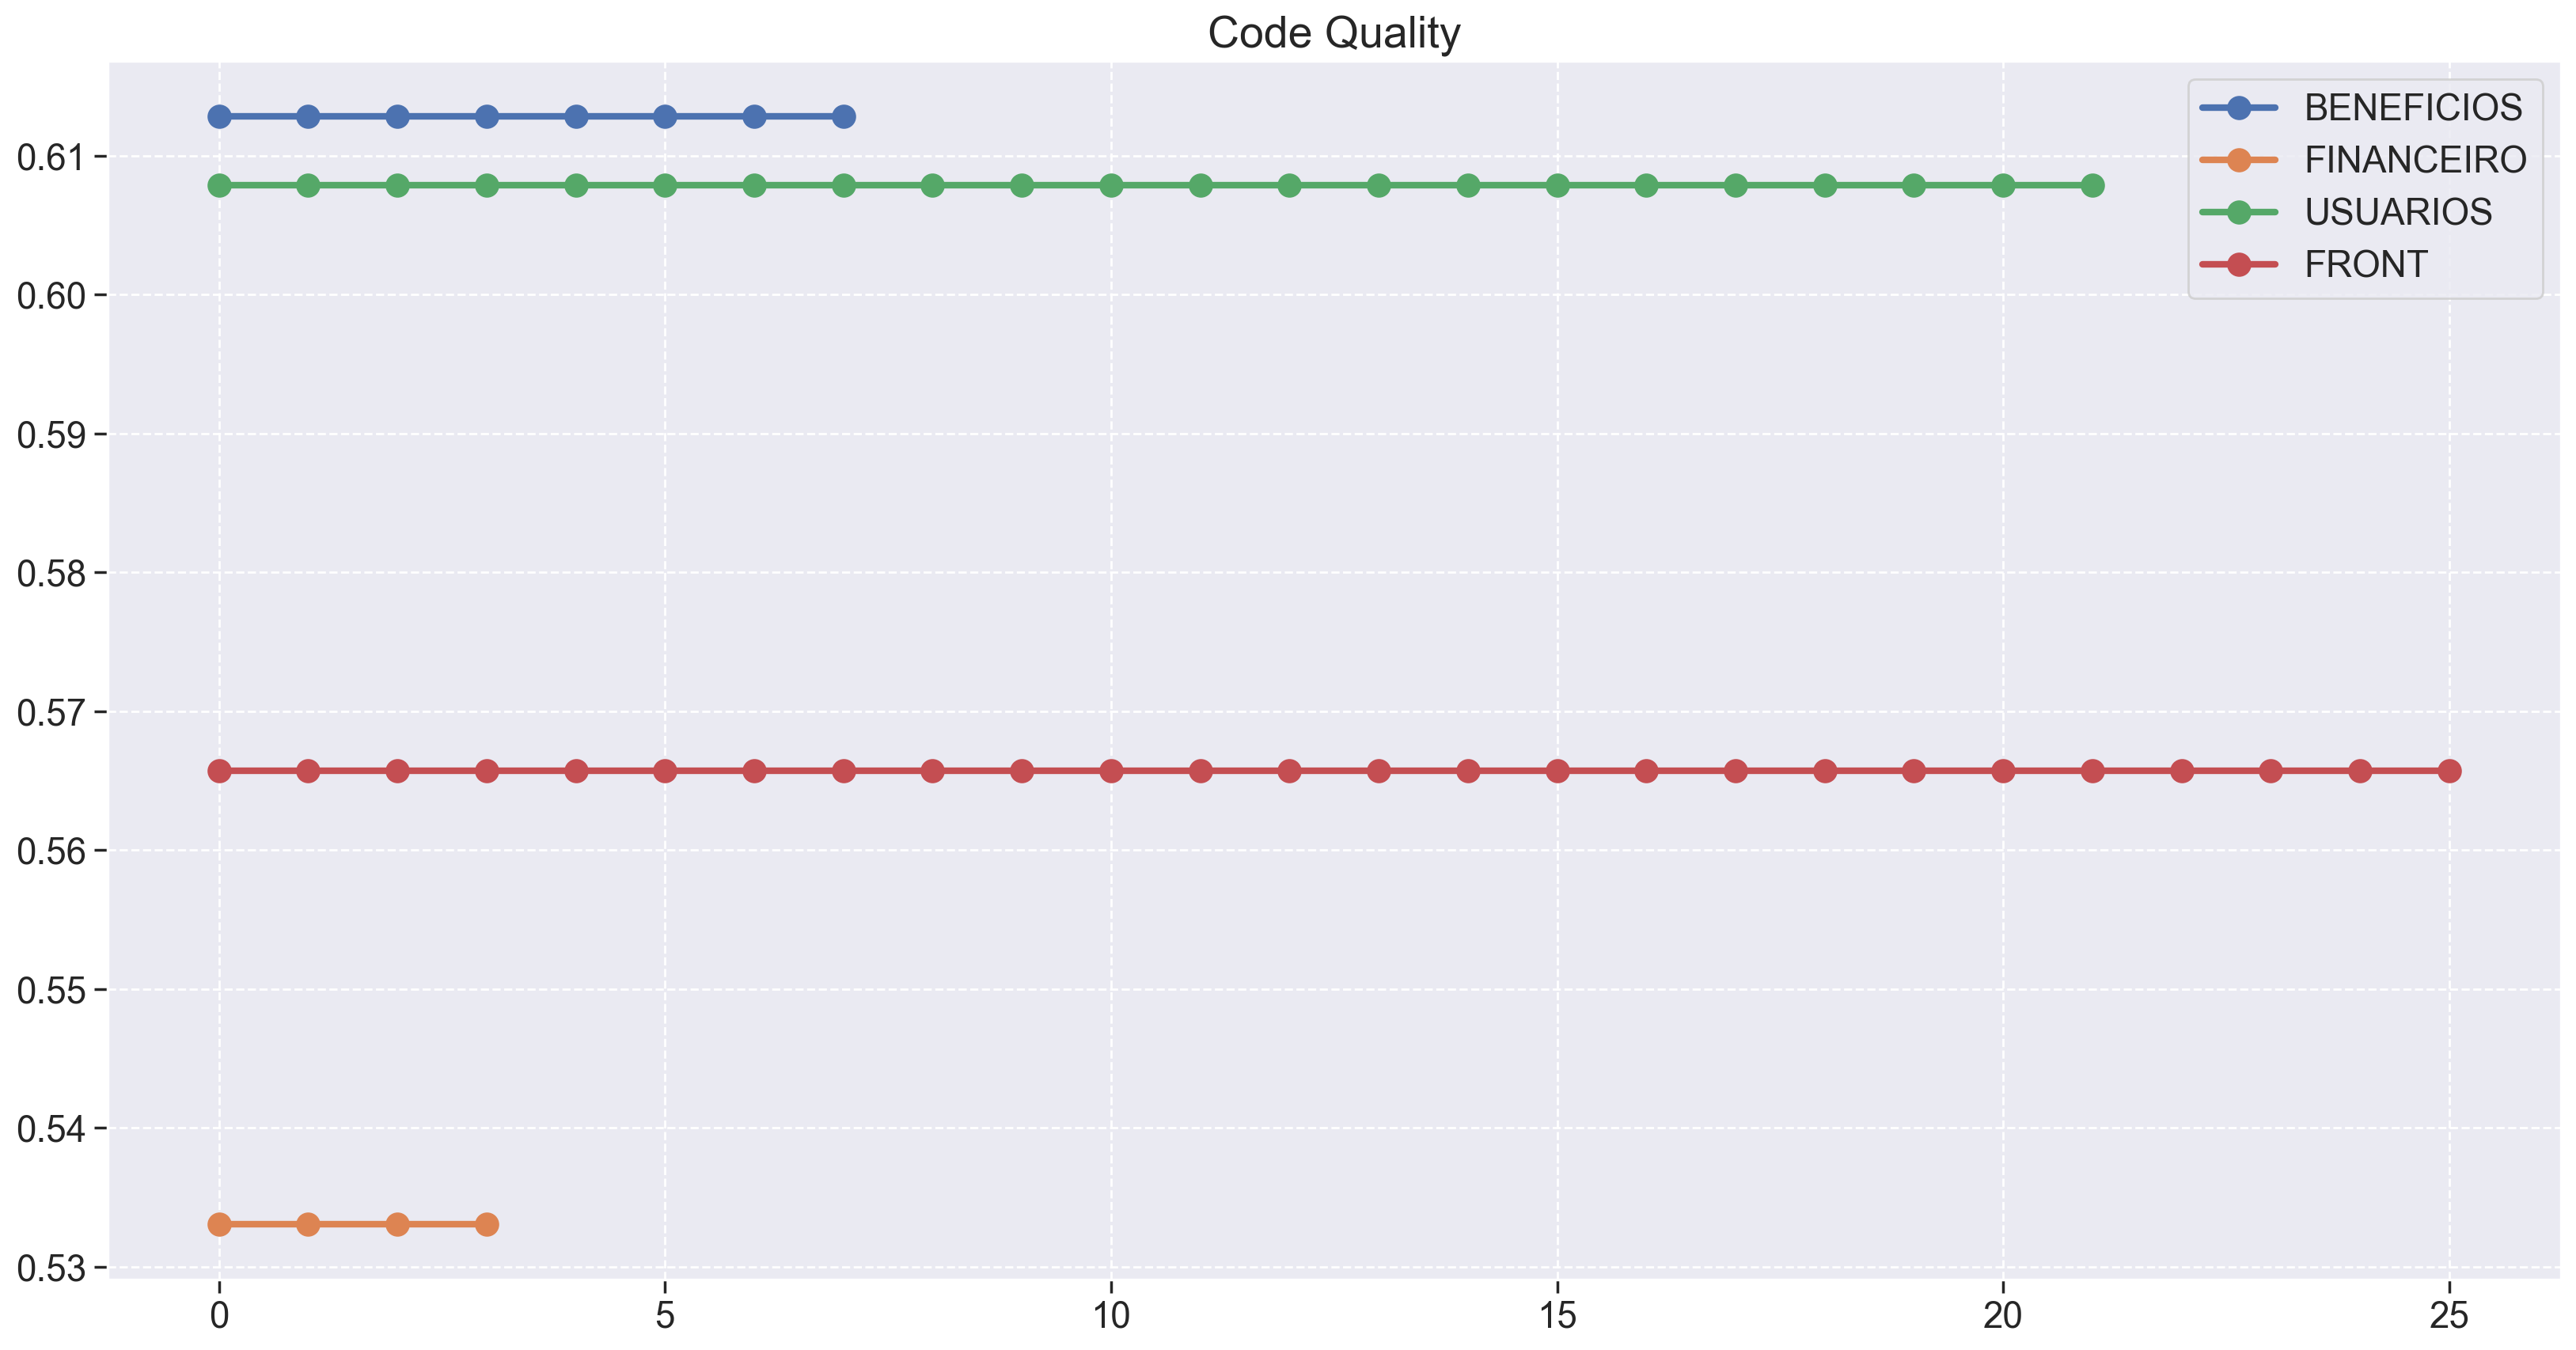

In [218]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

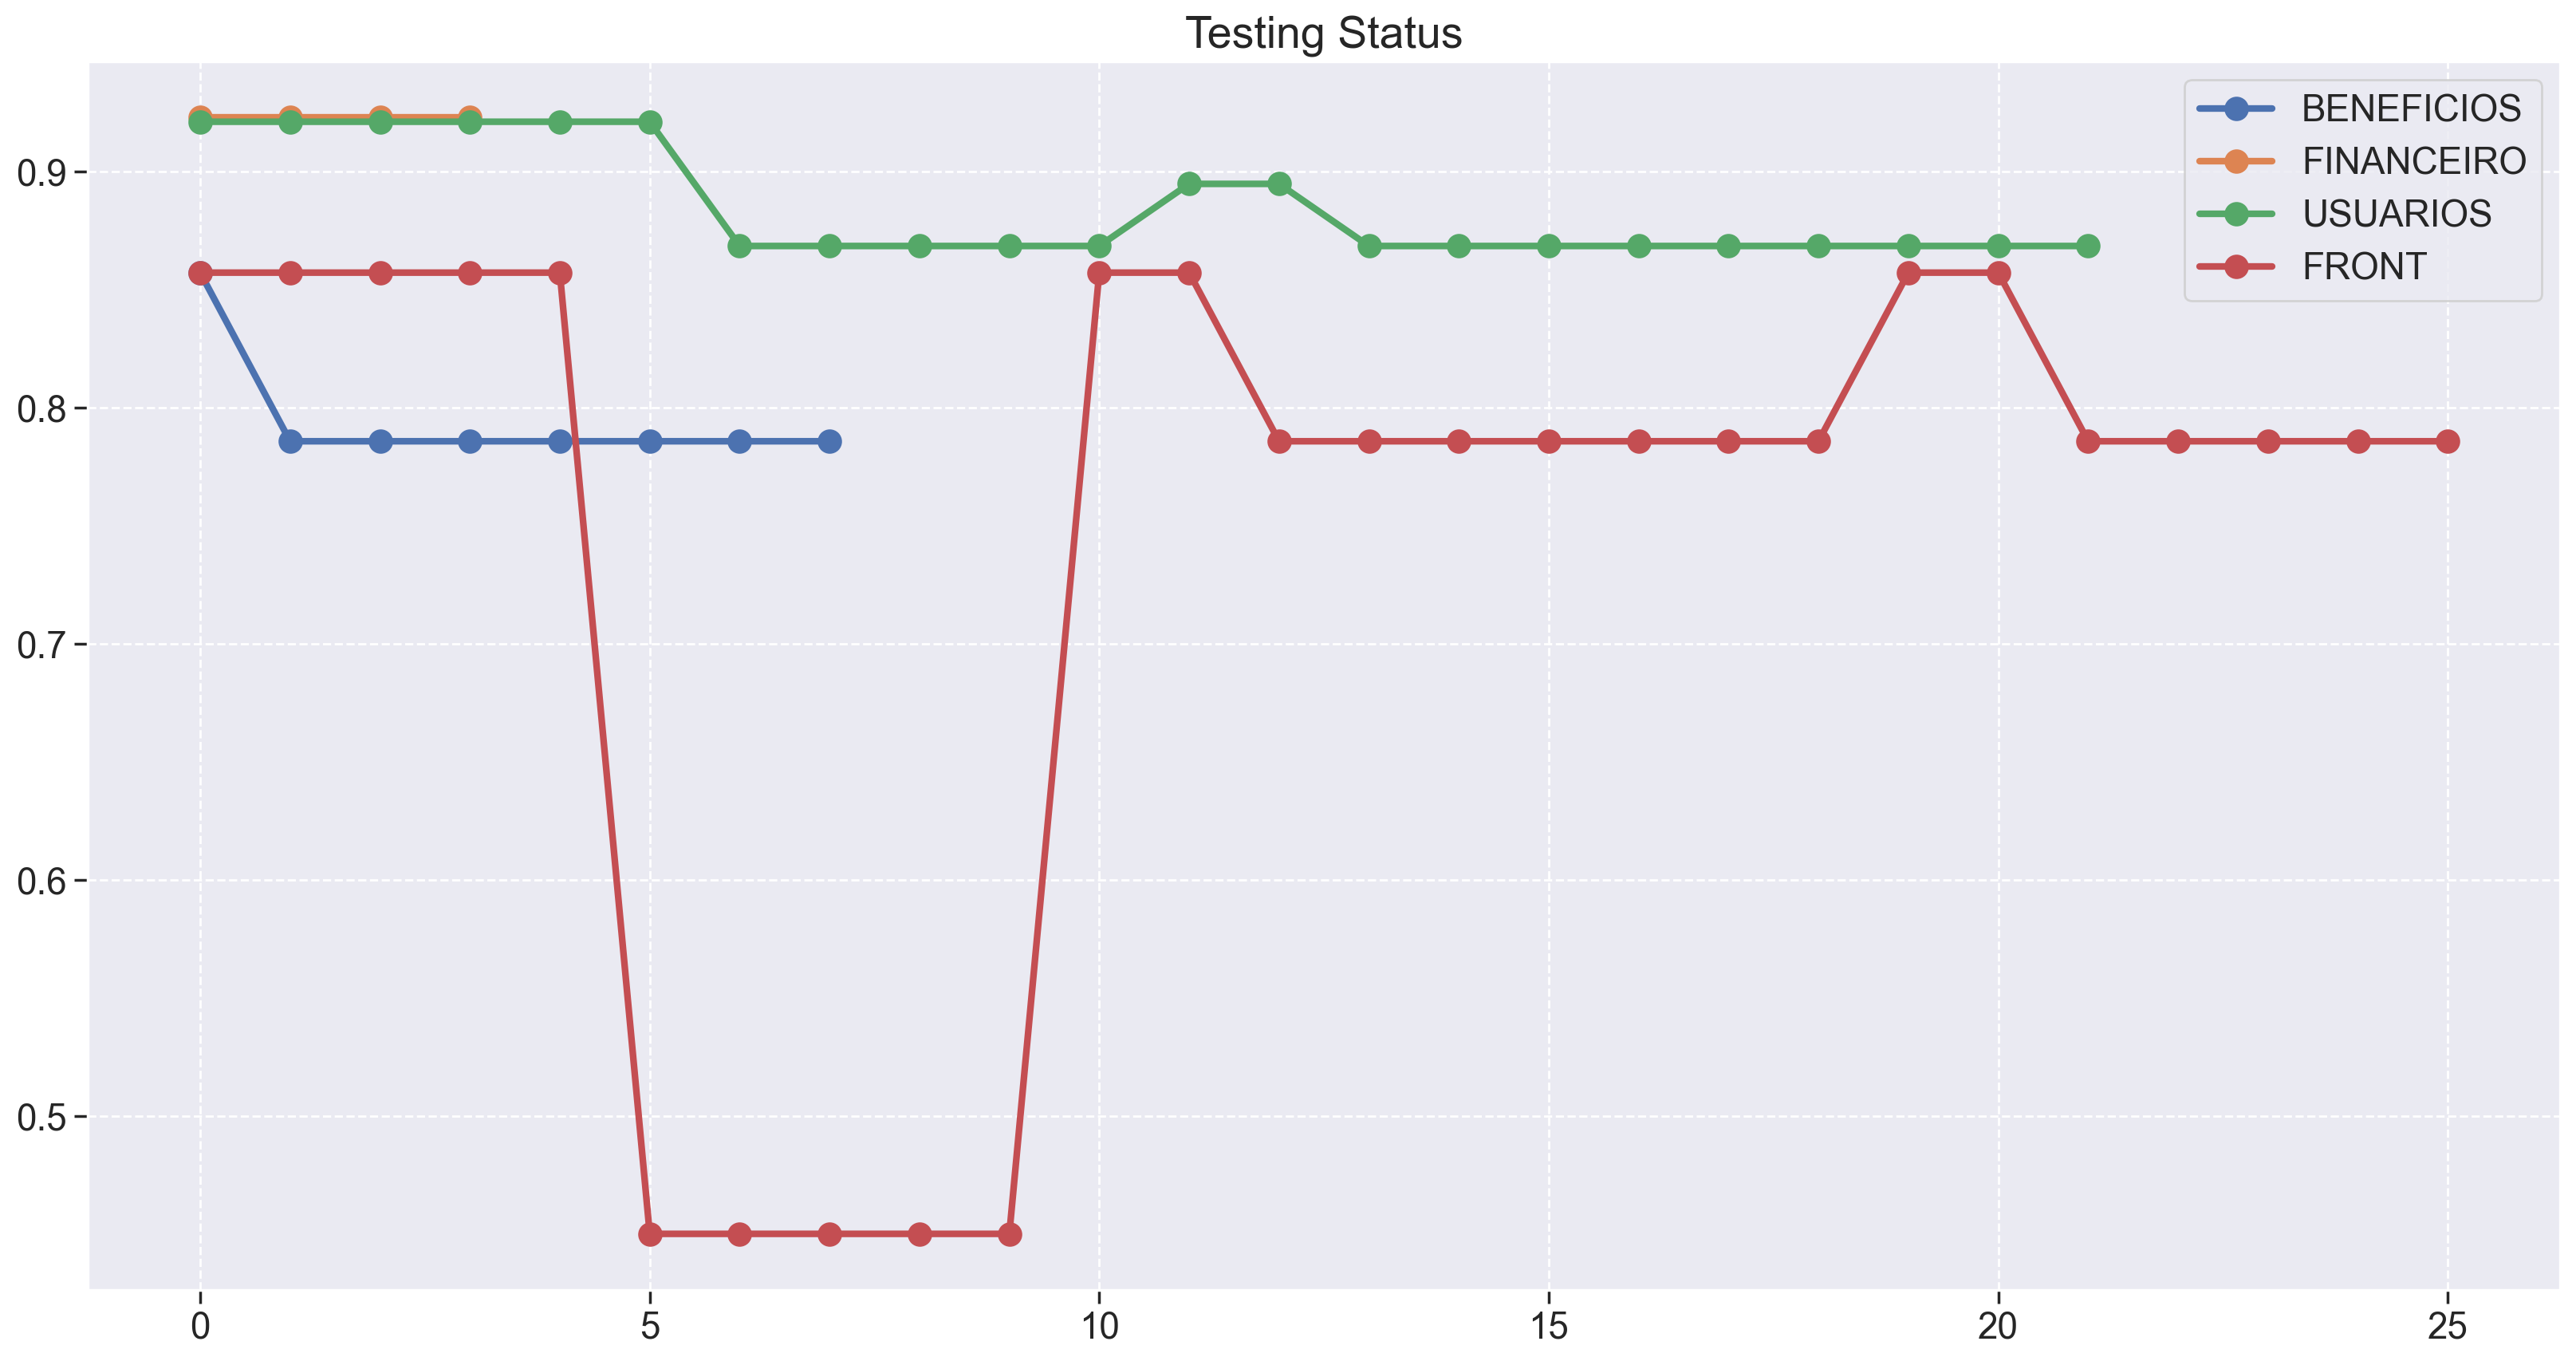

In [219]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [220]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [221]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [222]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

BENEFICIOS
Maintainability Stats
    mean     mode   median  std  var      min      max
0.306429 0.306429 0.306429  0.0  0.0 0.306429 0.306429
Reliability Stats
    mean     mode   median      std      var      min      max
0.397321 0.392857 0.392857 0.012627 0.000159 0.392857 0.428571


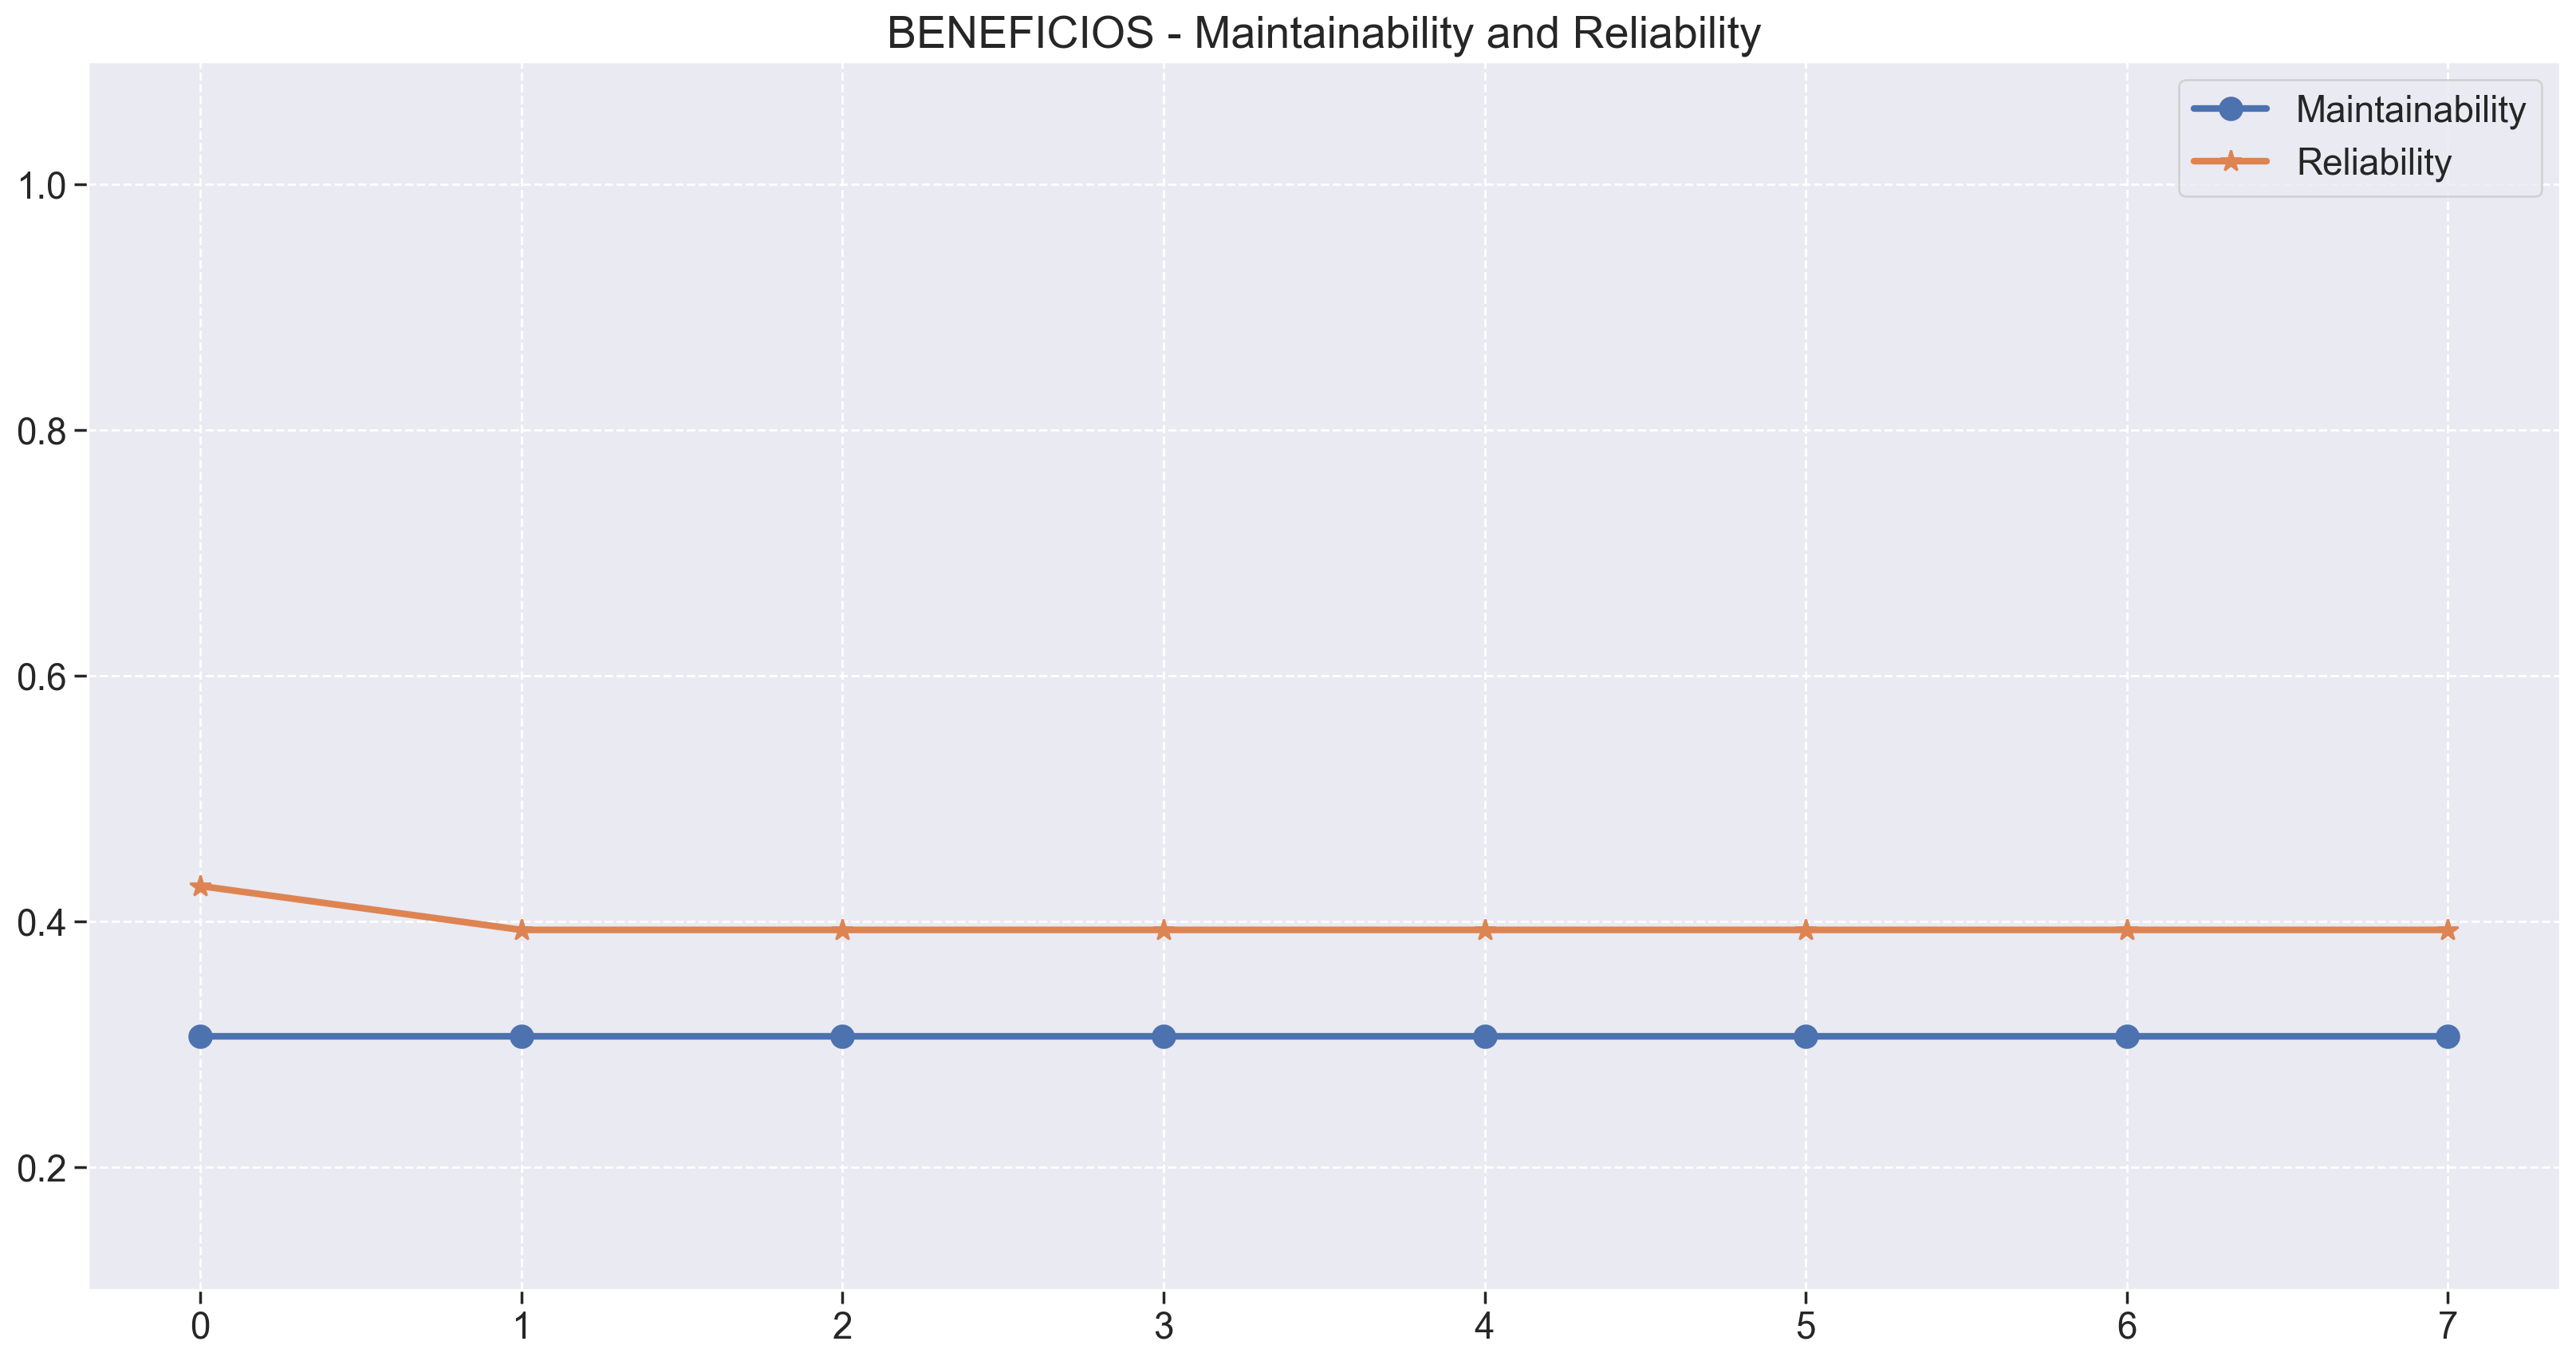

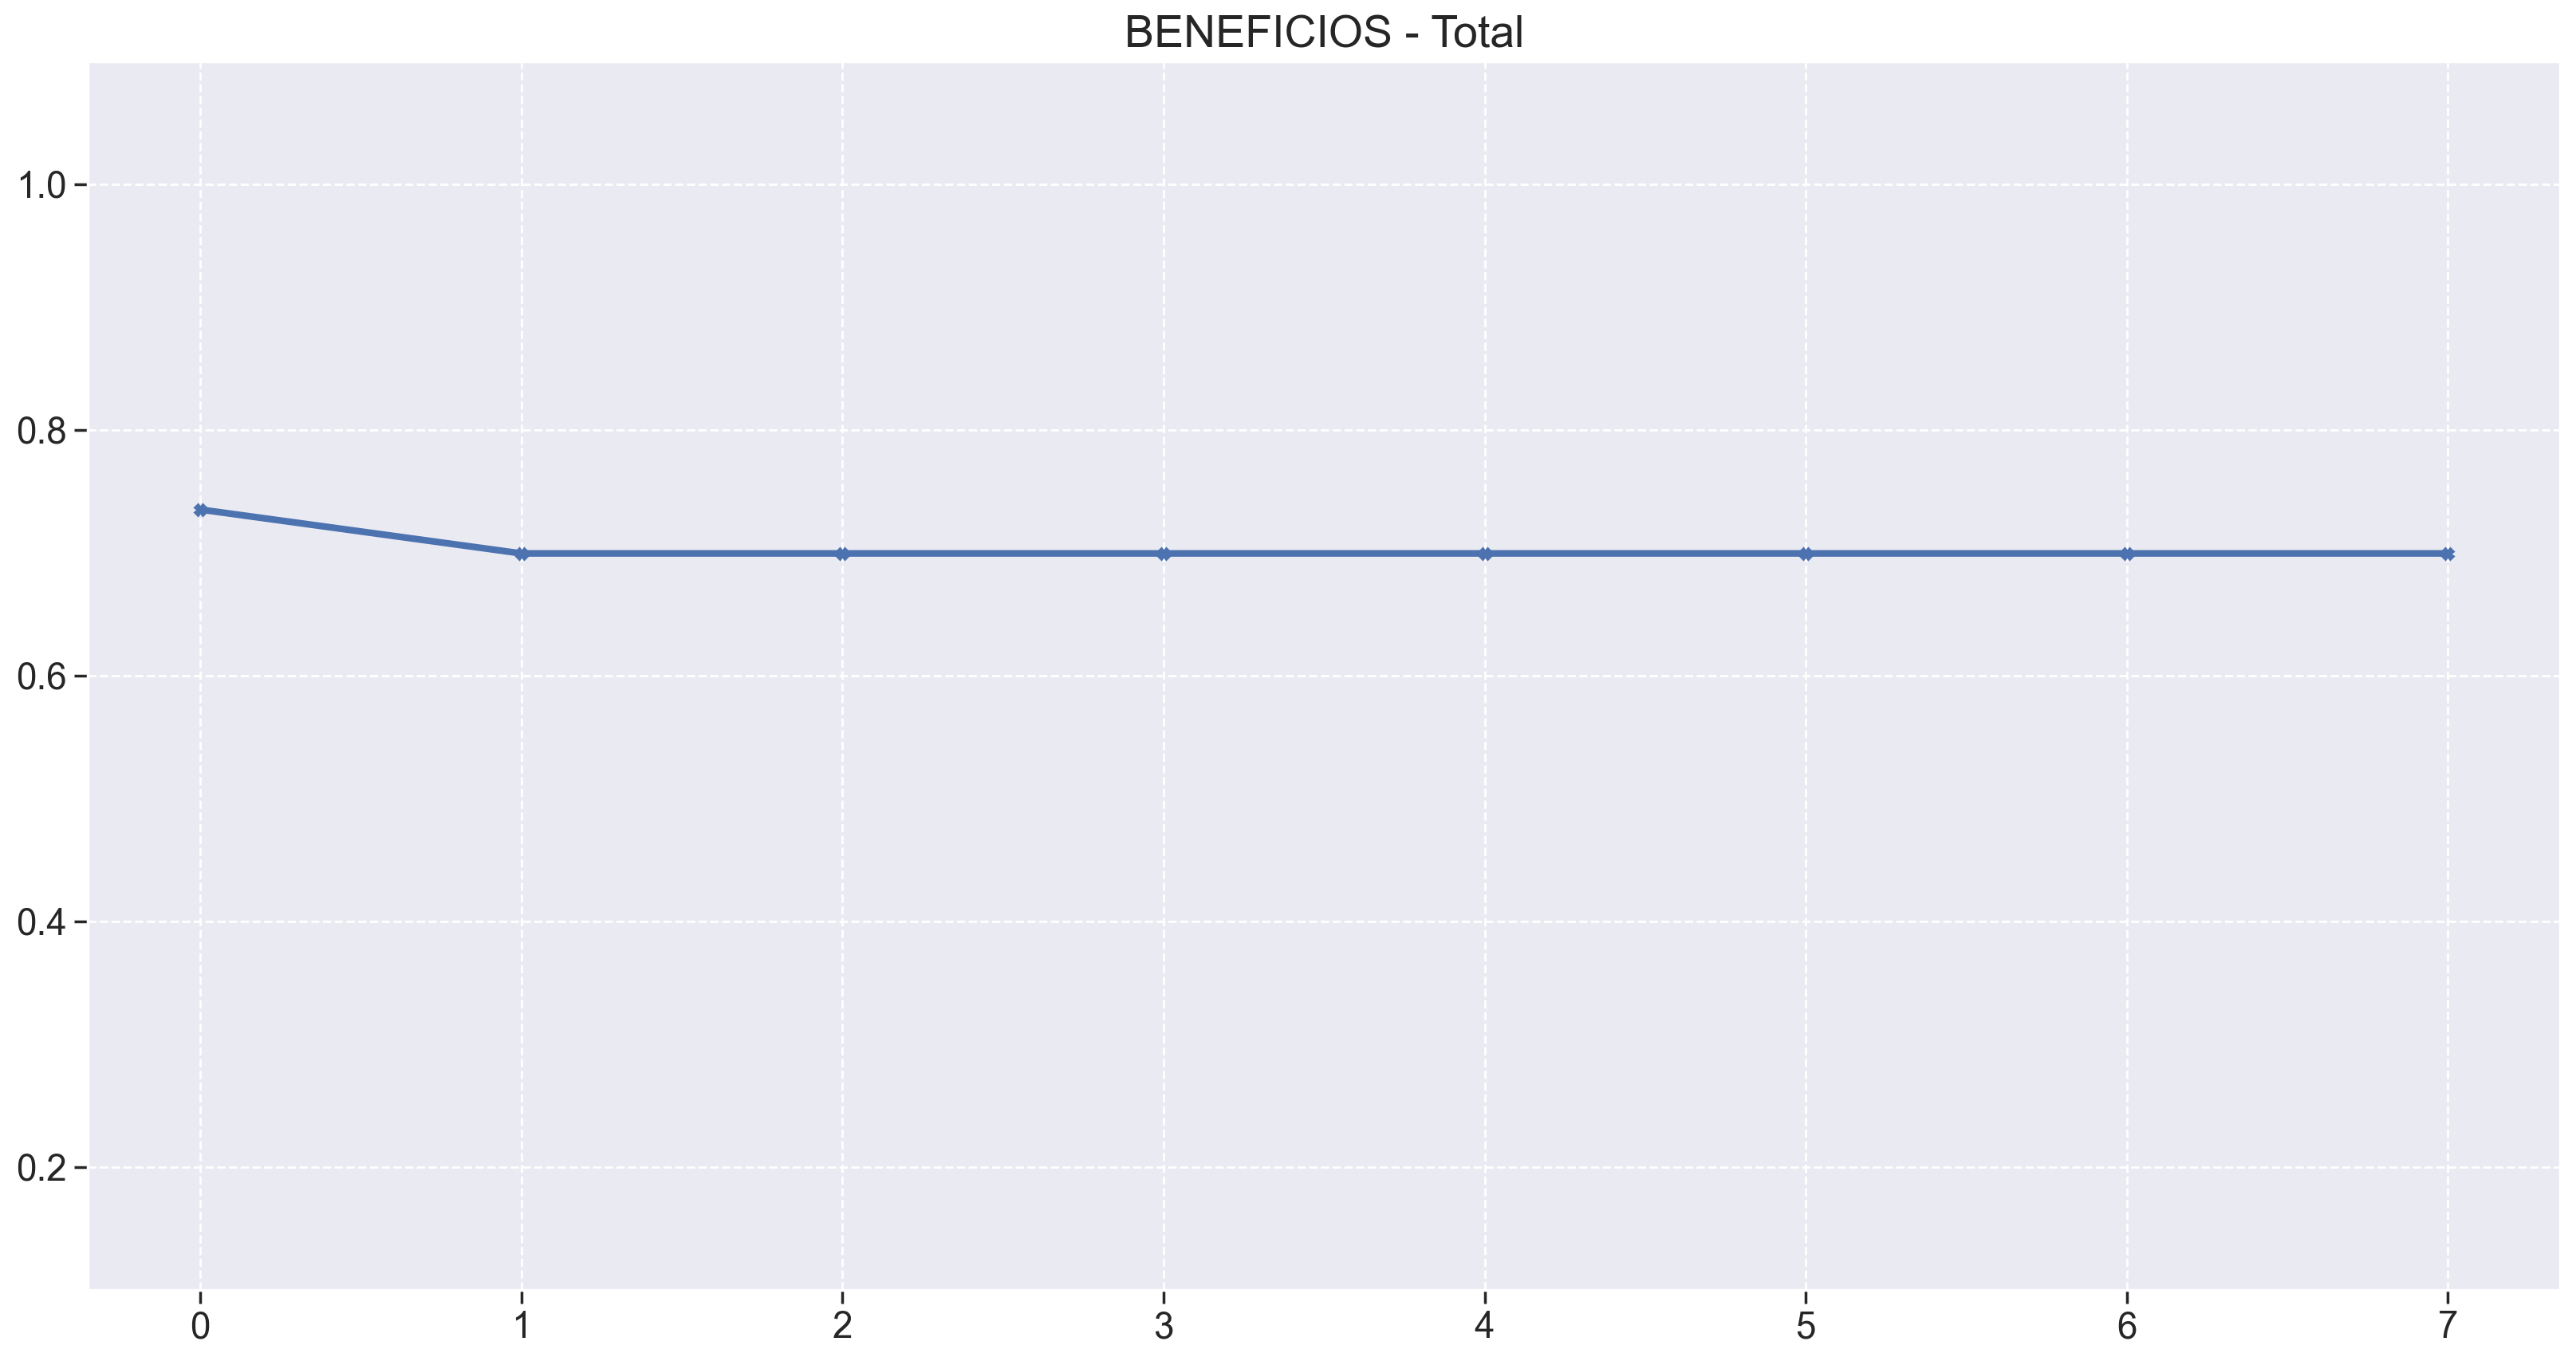

FINANCEIRO
Maintainability Stats
    mean     mode   median  std  var      min      max
0.266538 0.266538 0.266538  0.0  0.0 0.266538 0.266538
Reliability Stats
    mean     mode   median  std  var      min      max
0.461538 0.461538 0.461538  0.0  0.0 0.461538 0.461538


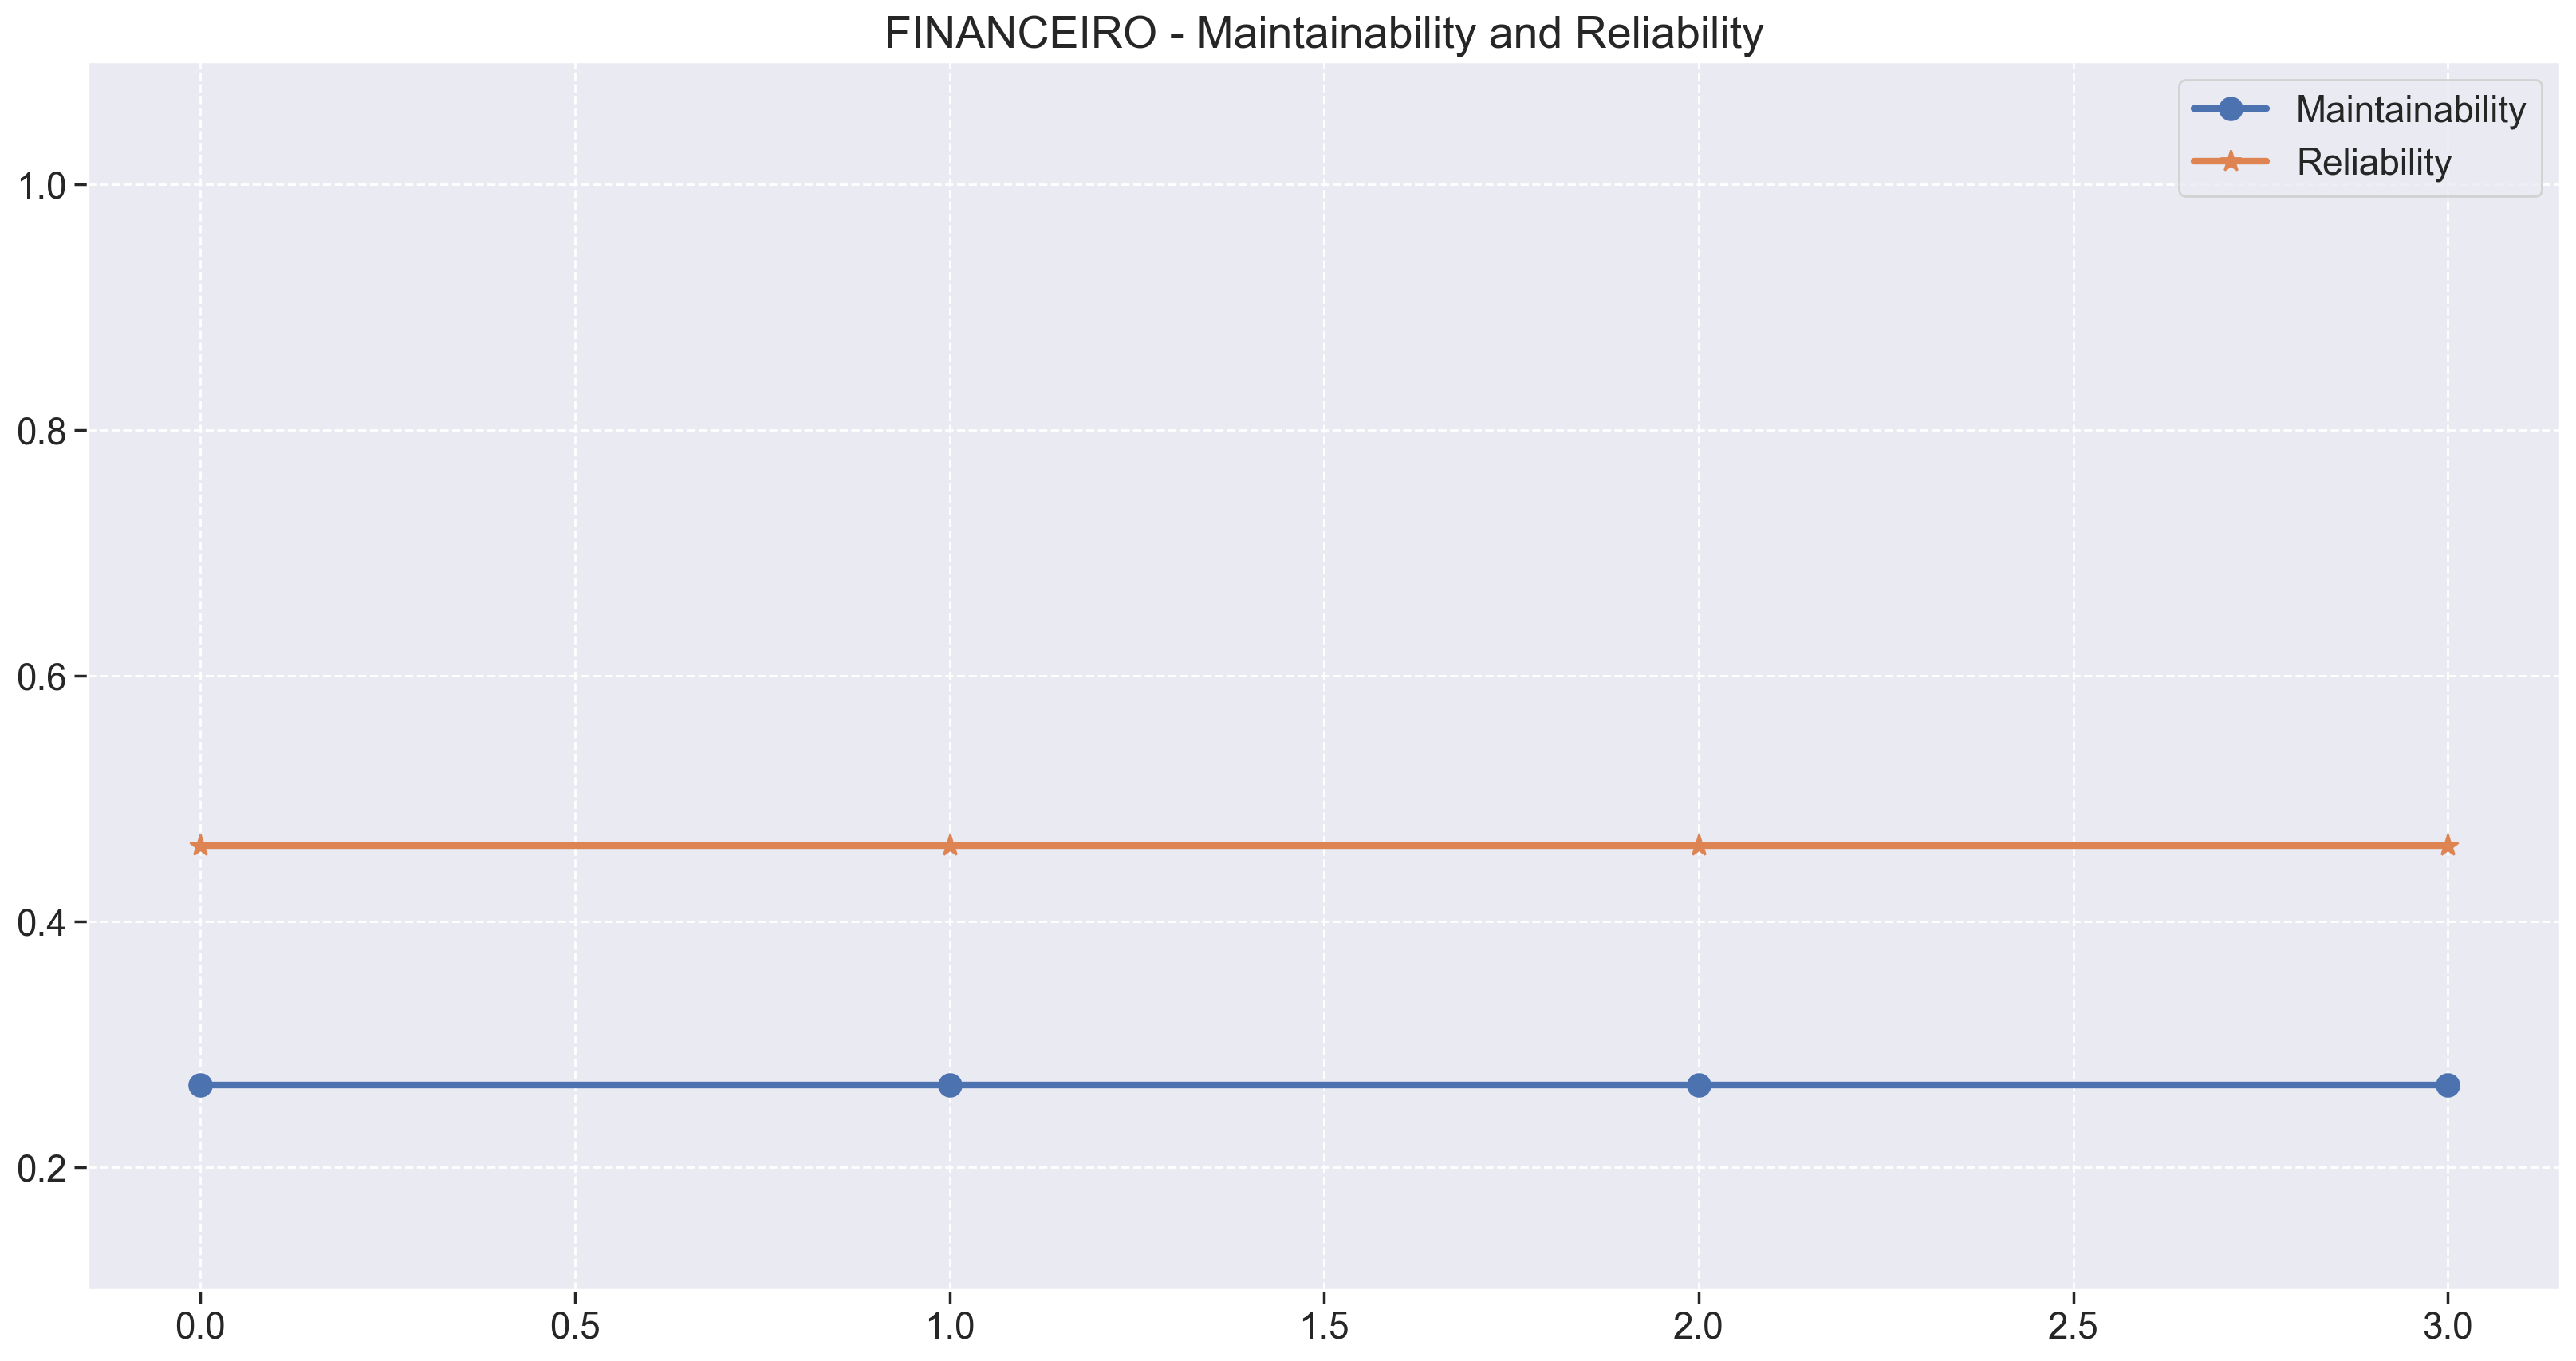

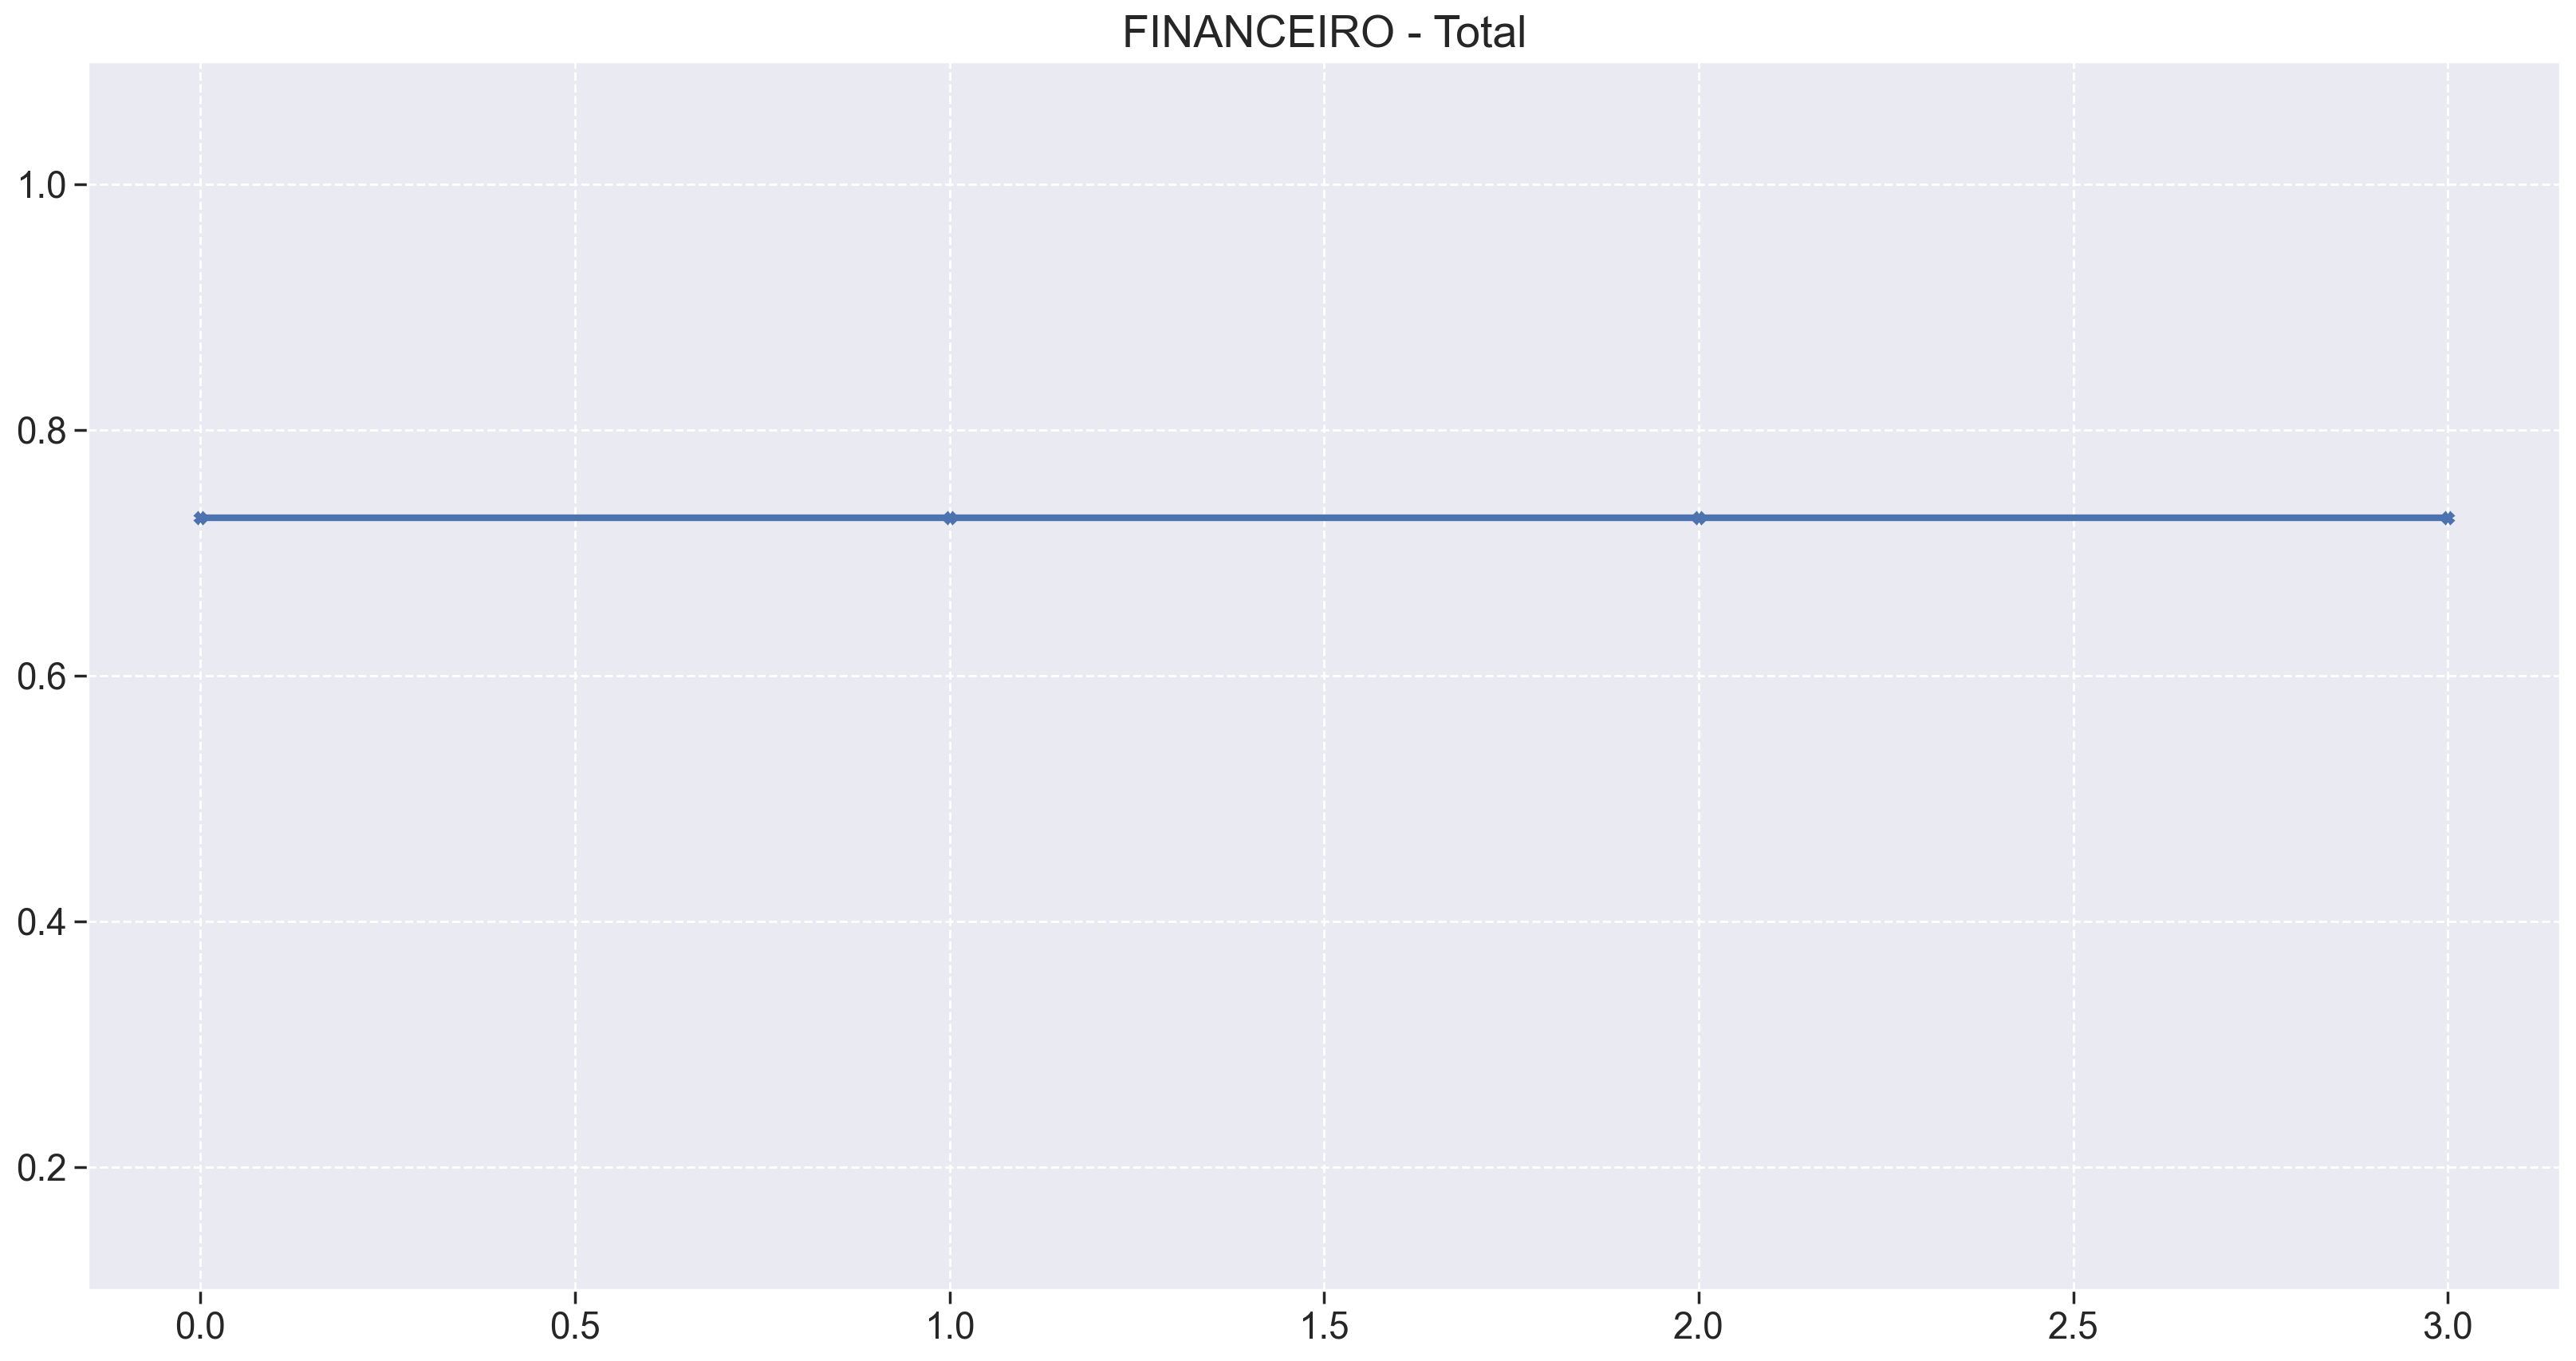

USUARIOS
Maintainability Stats
    mean     mode   median          std          var      min      max
0.303947 0.303947 0.303947 5.681747e-17 3.228225e-33 0.303947 0.303947
Reliability Stats
    mean     mode   median     std      var      min      max
0.442584 0.434211 0.434211 0.01187 0.000141 0.434211 0.460526


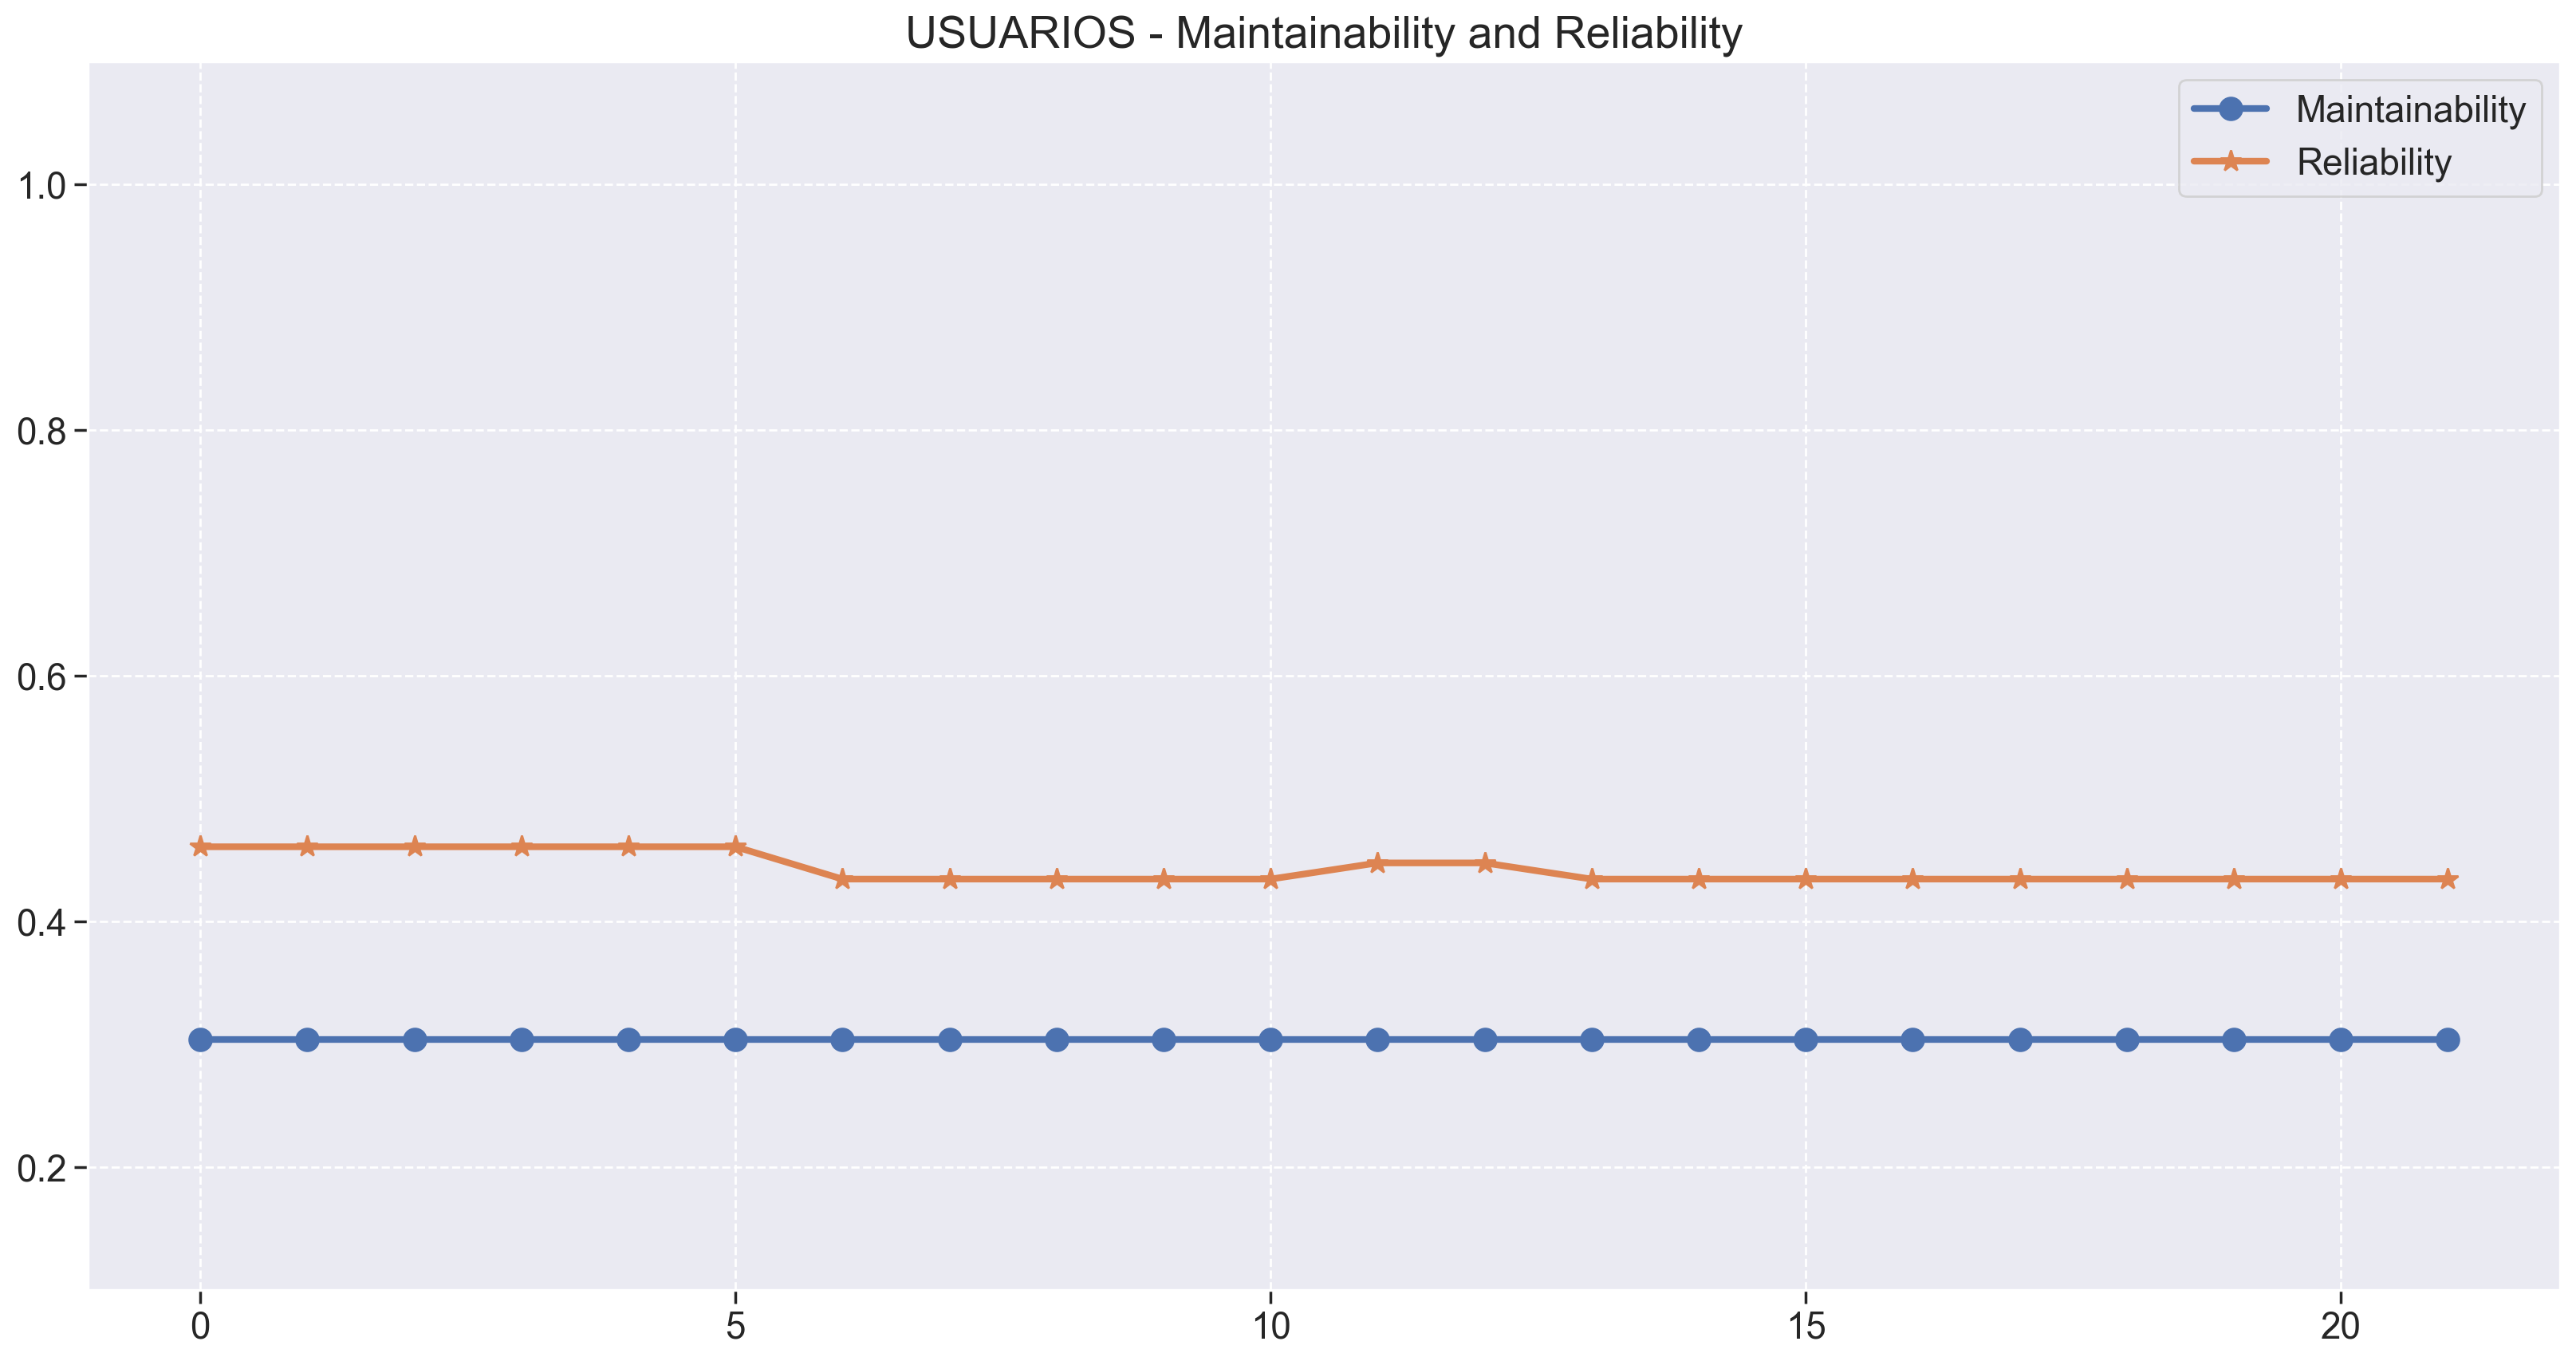

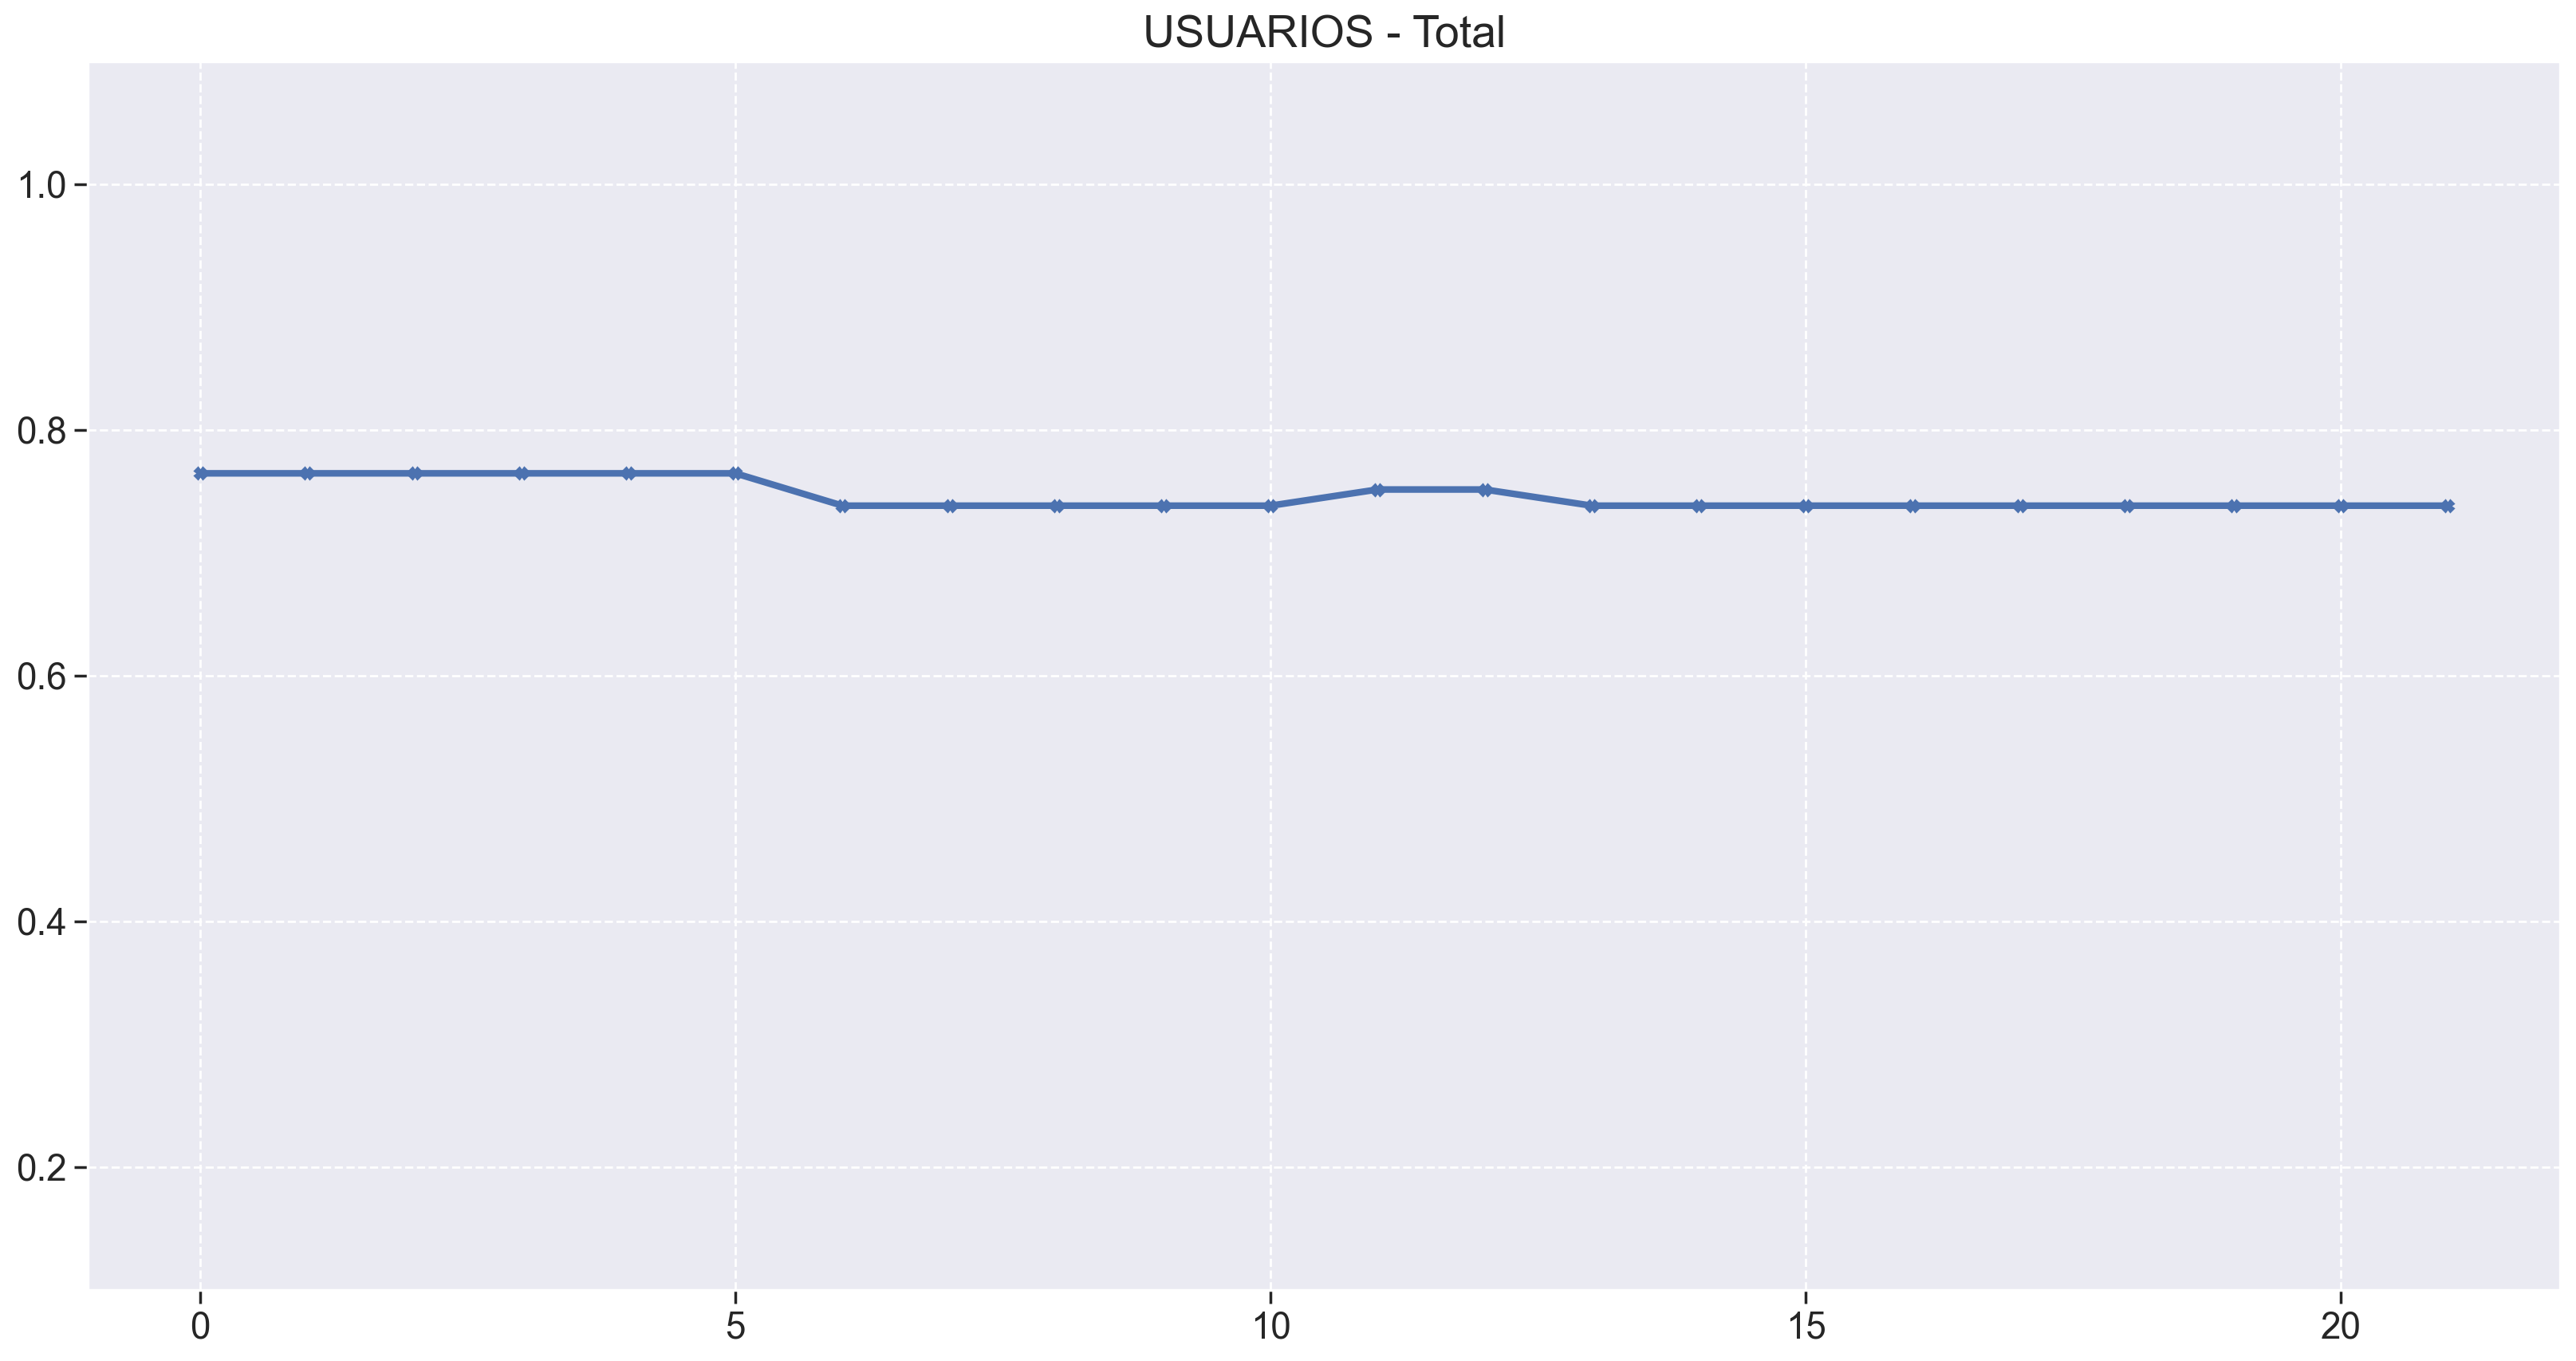

FRONT
Maintainability Stats
    mean     mode   median  std  var      min      max
0.282857 0.282857 0.282857  0.0  0.0 0.282857 0.282857
Reliability Stats
   mean     mode   median      std      var   min      max
0.37294 0.392857 0.392857 0.075378 0.005682 0.225 0.428571


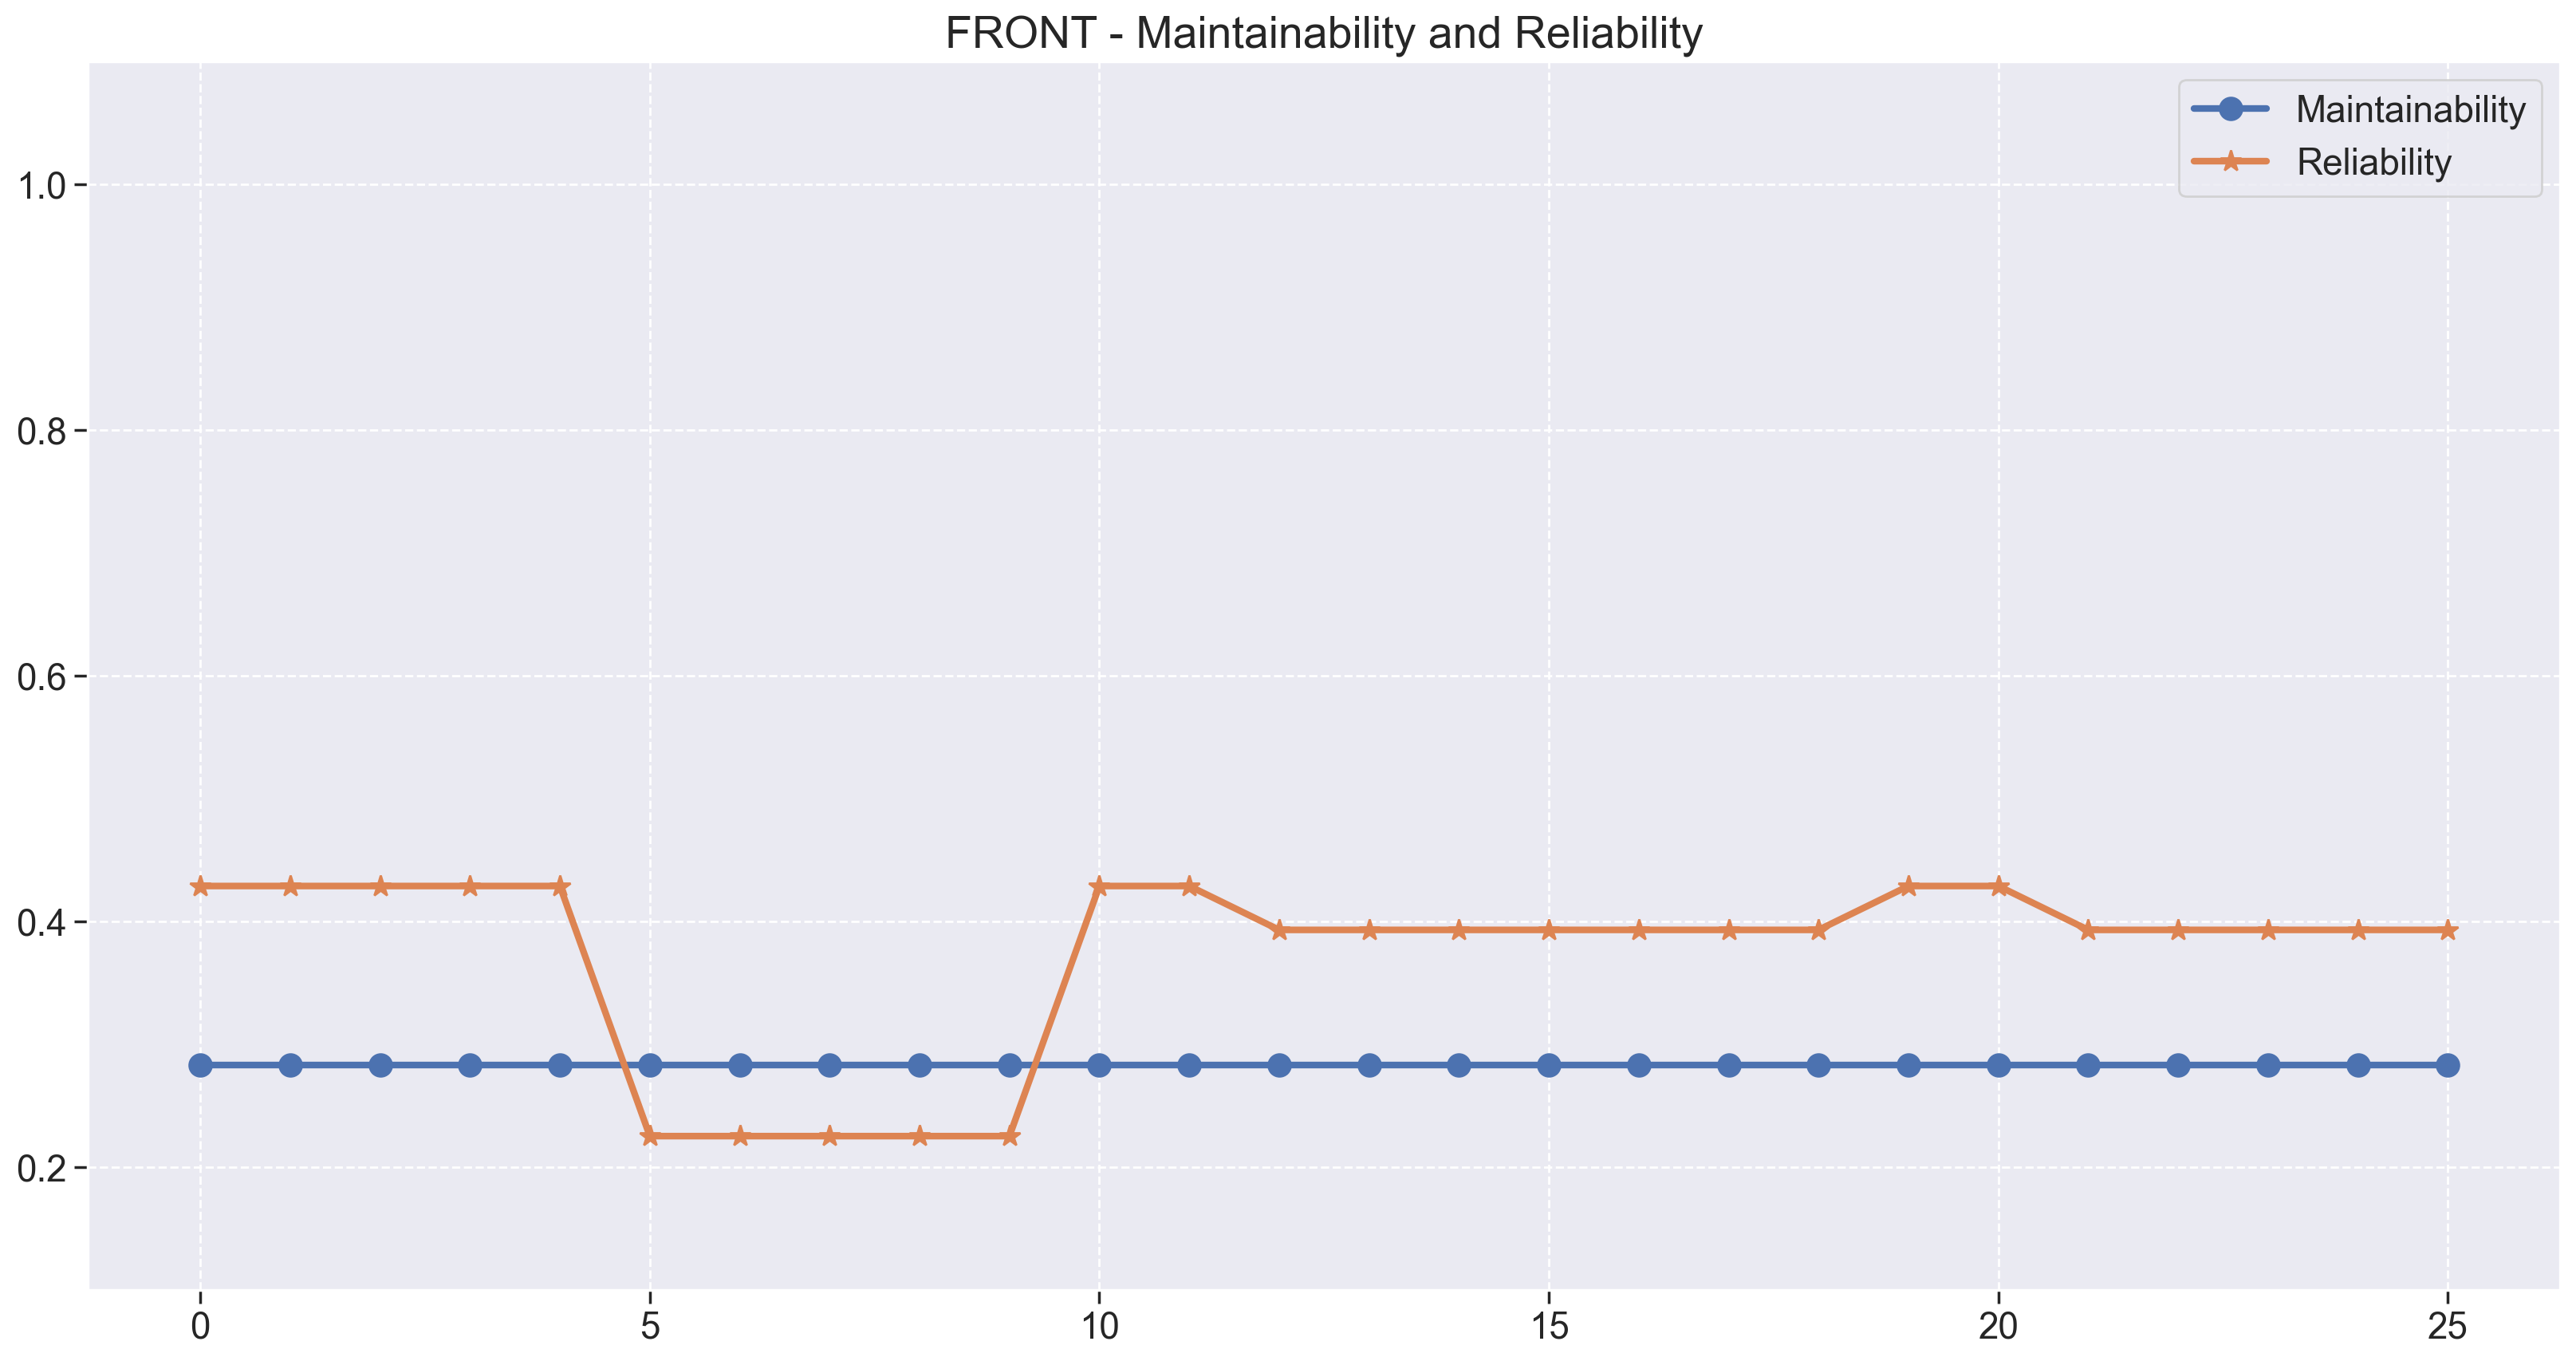

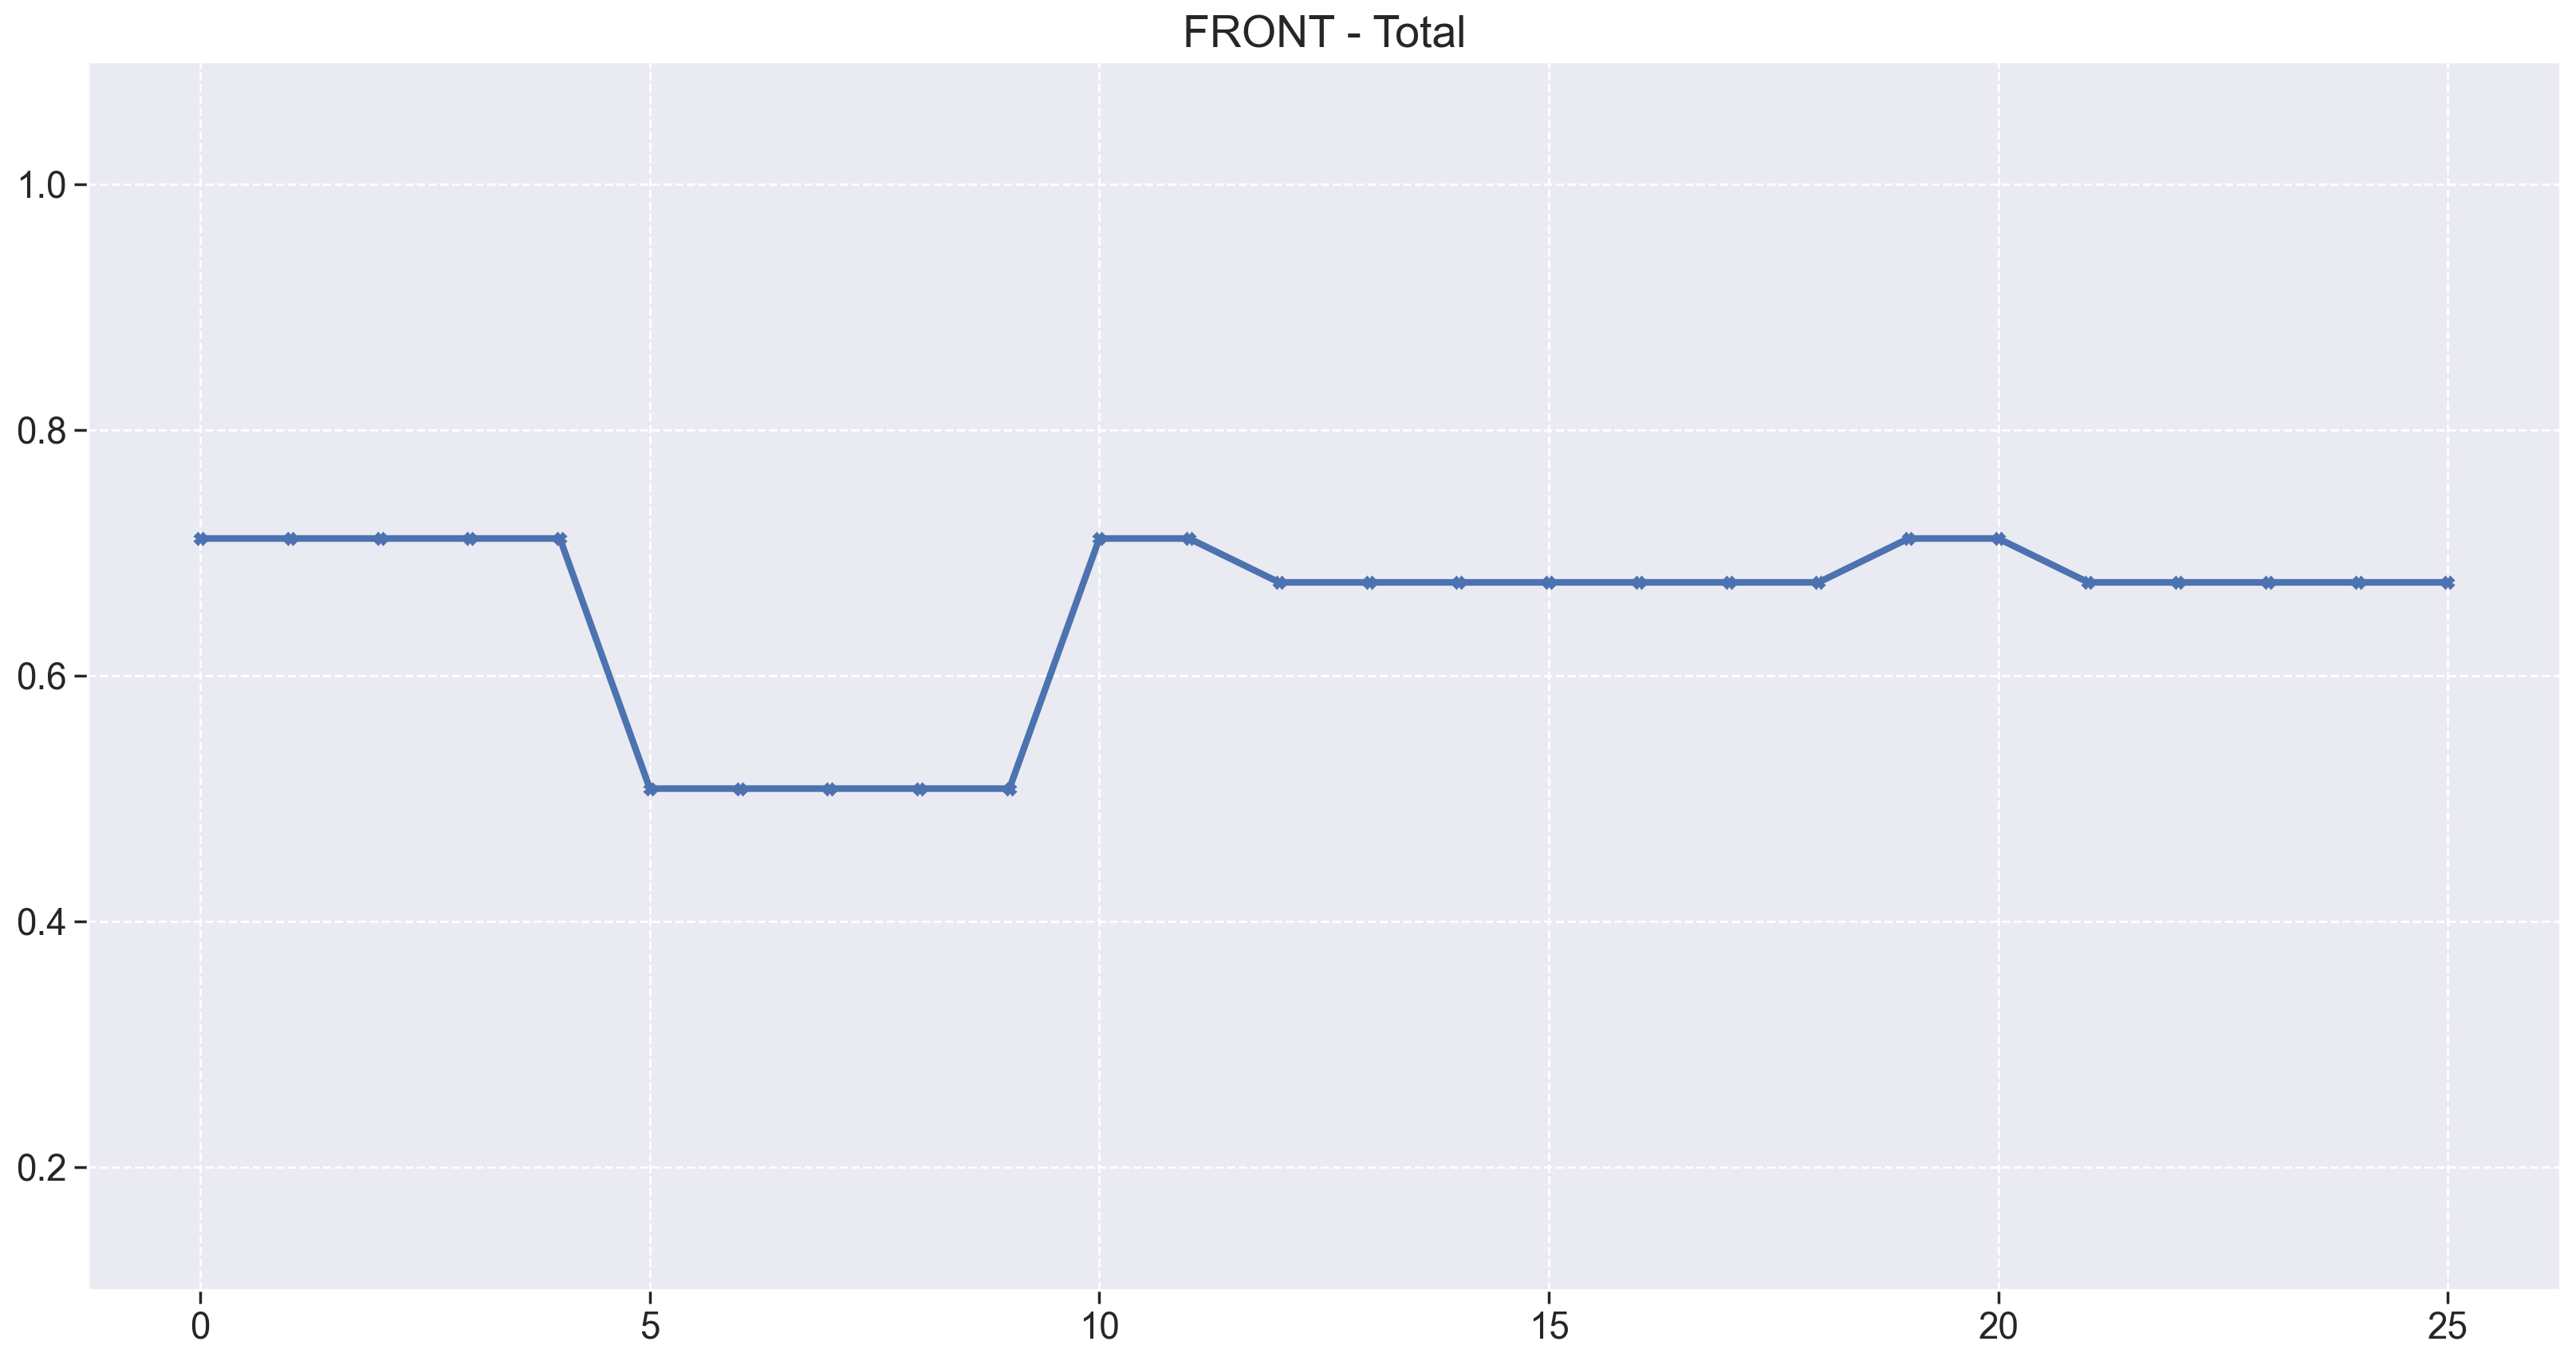

In [223]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

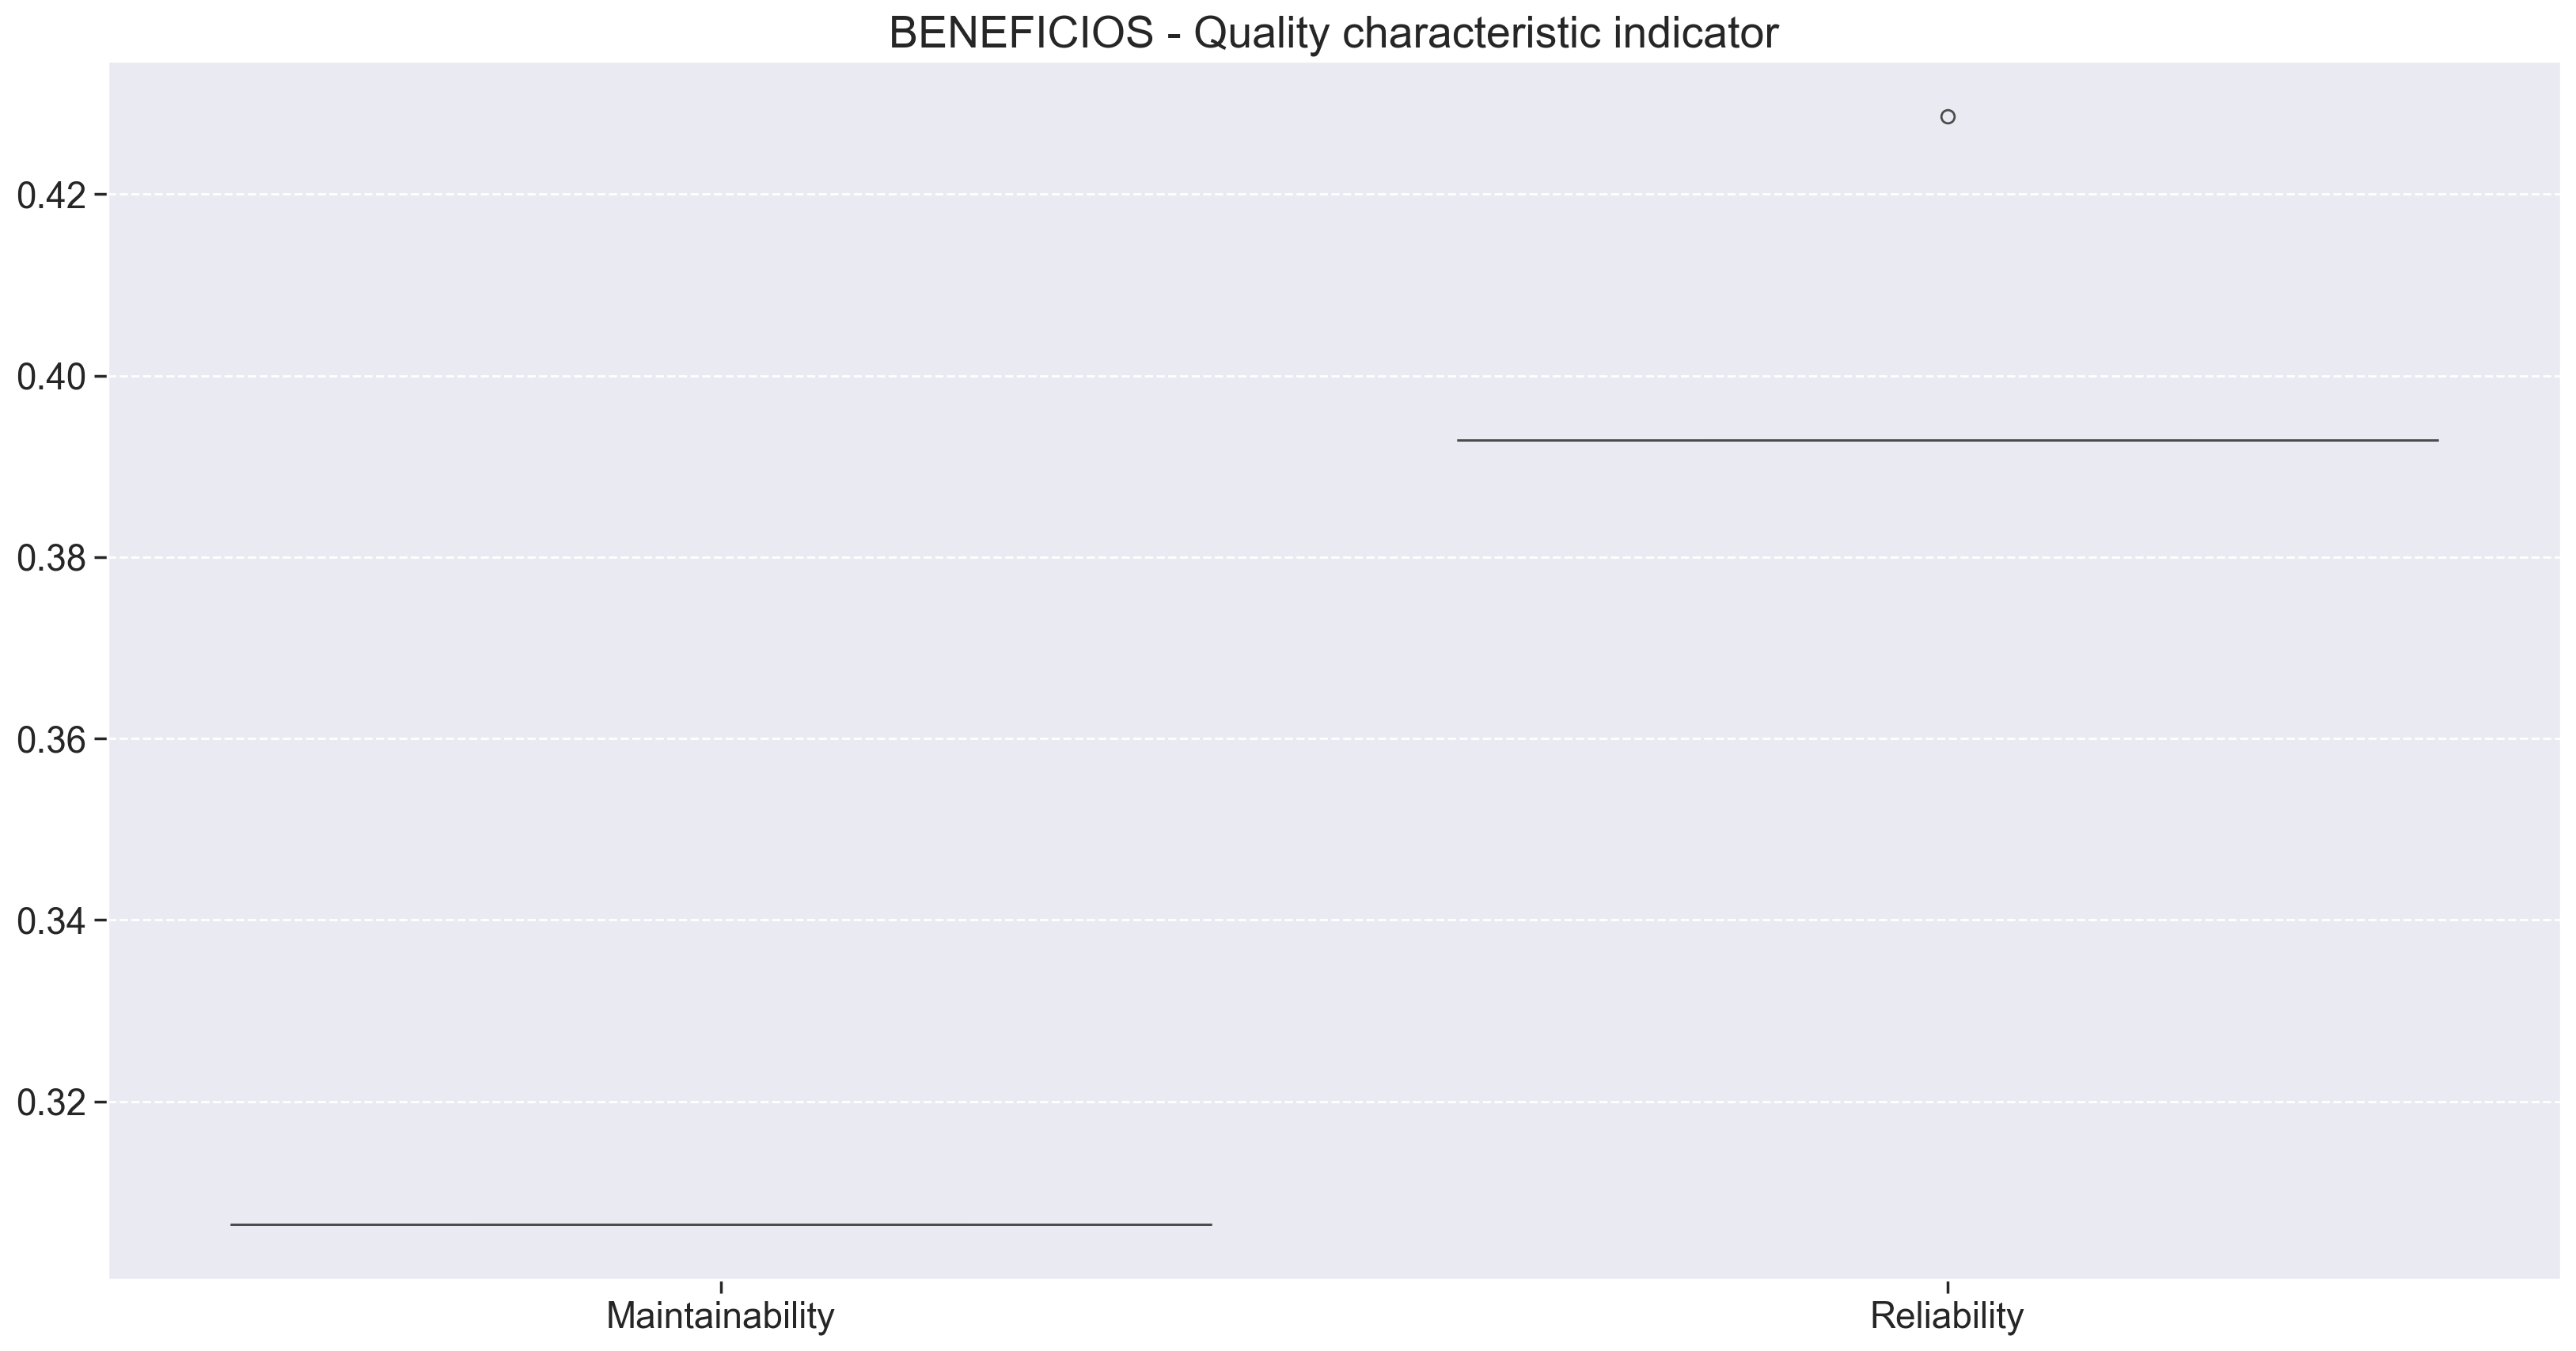

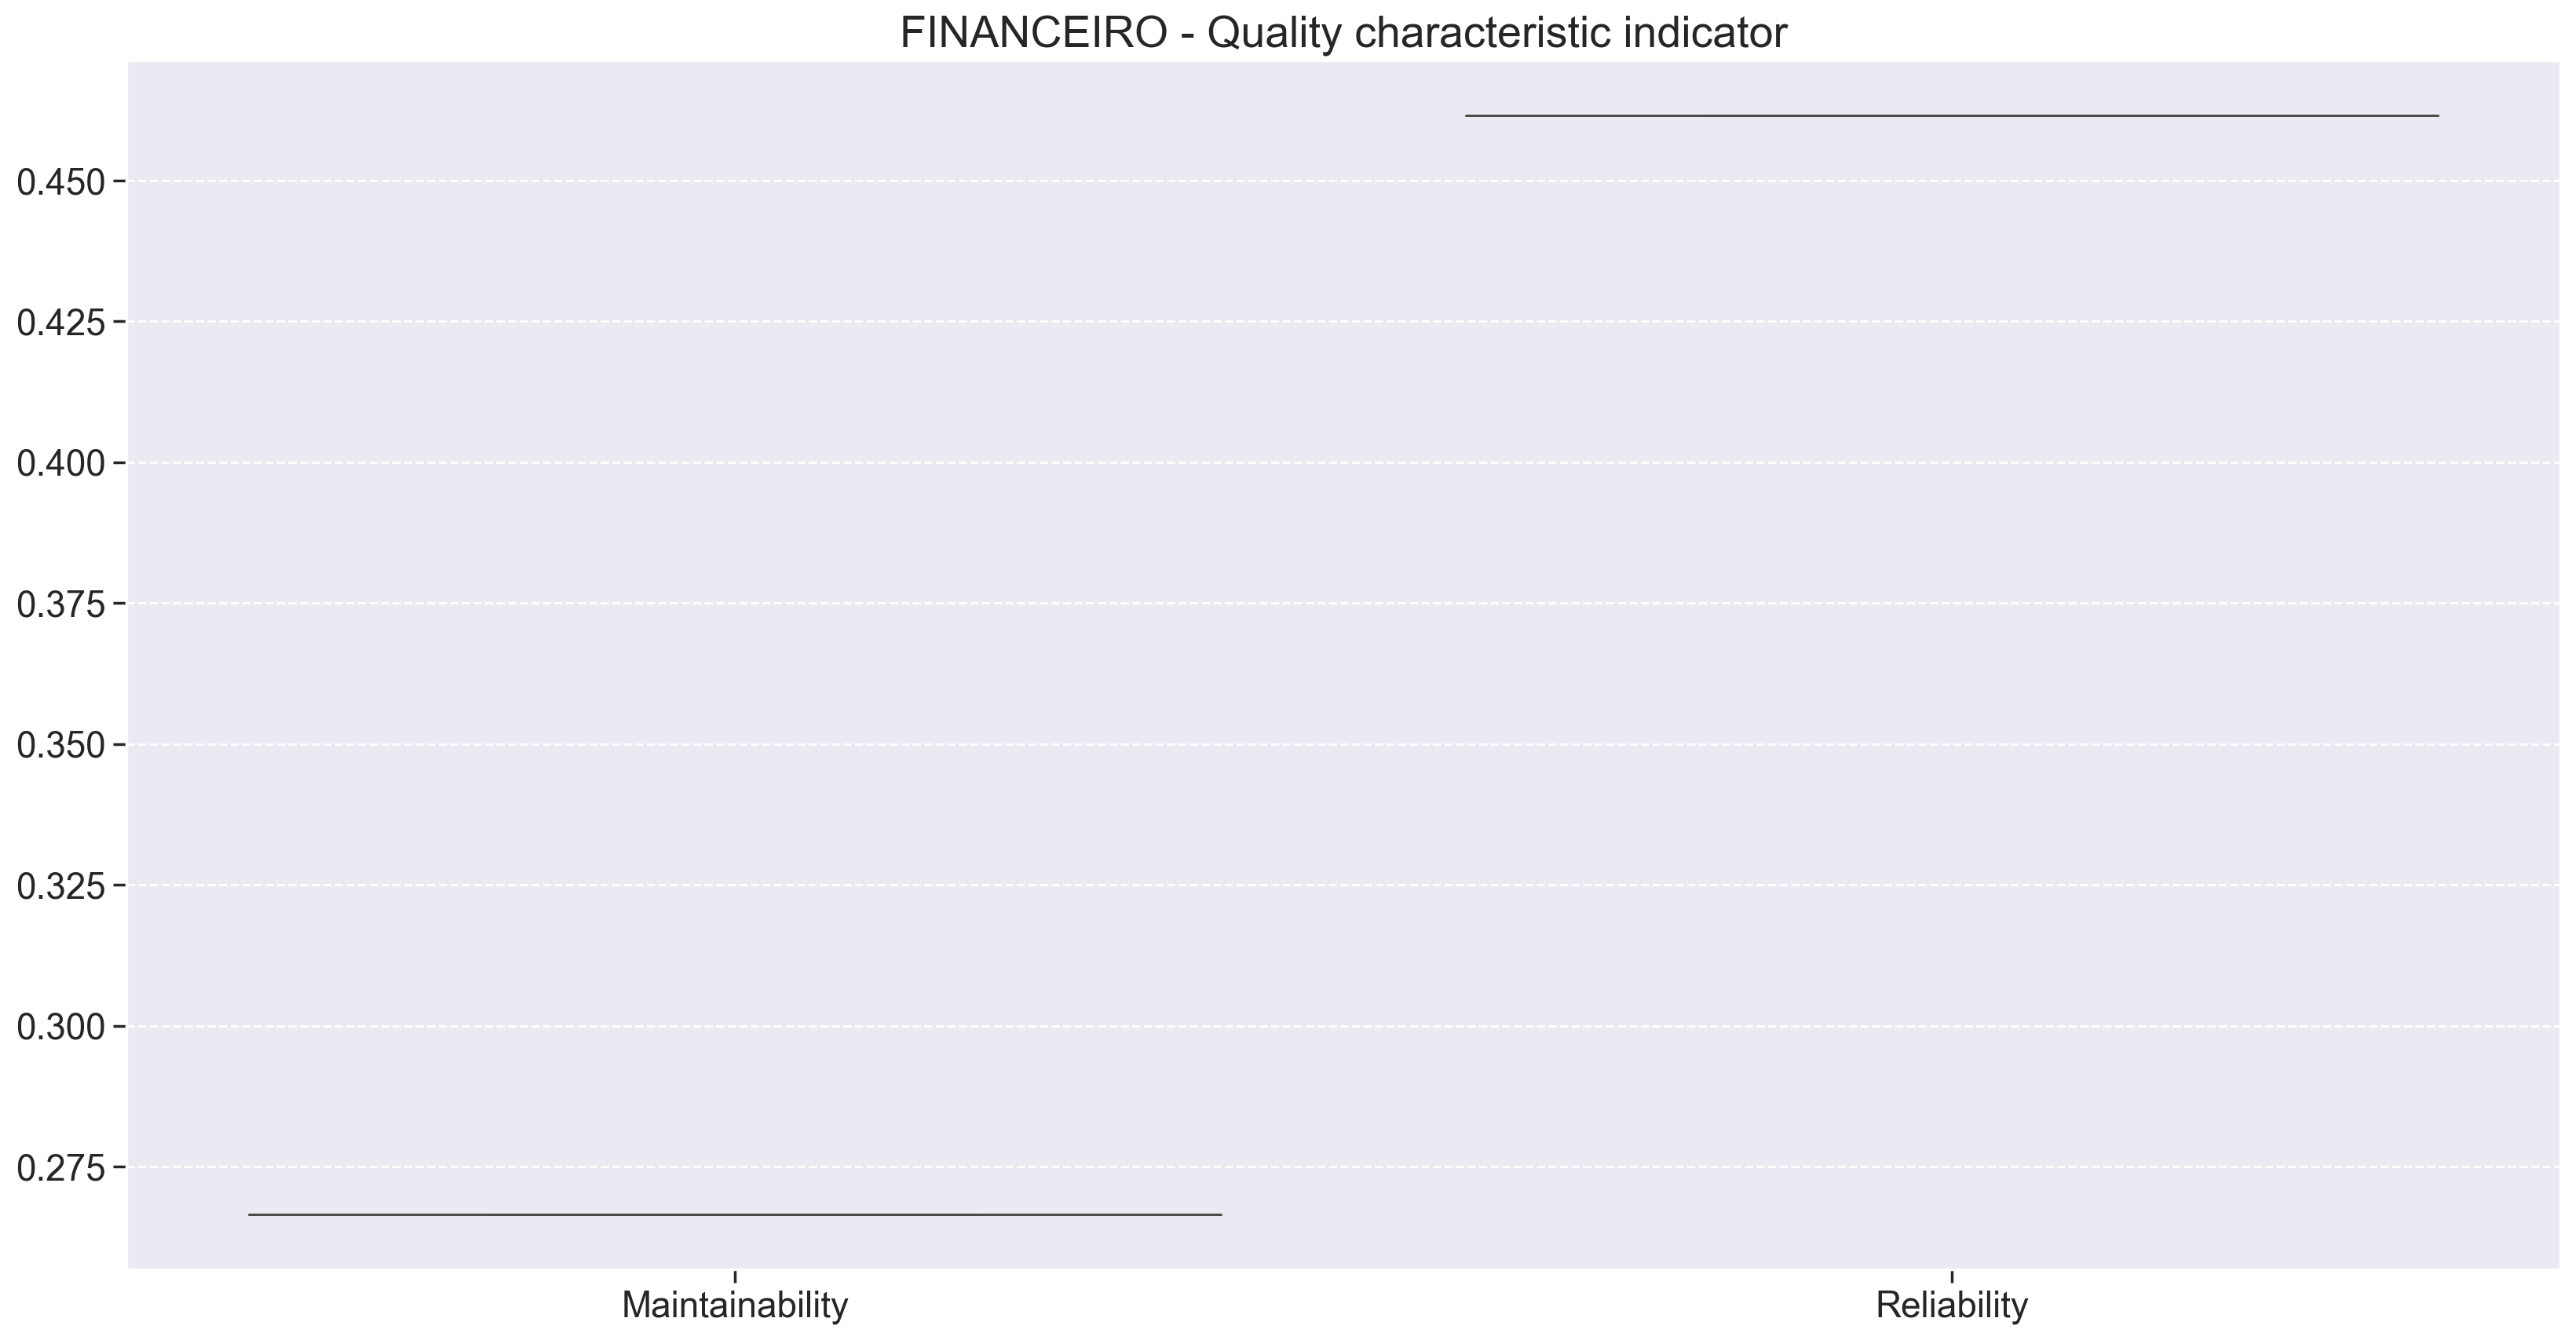

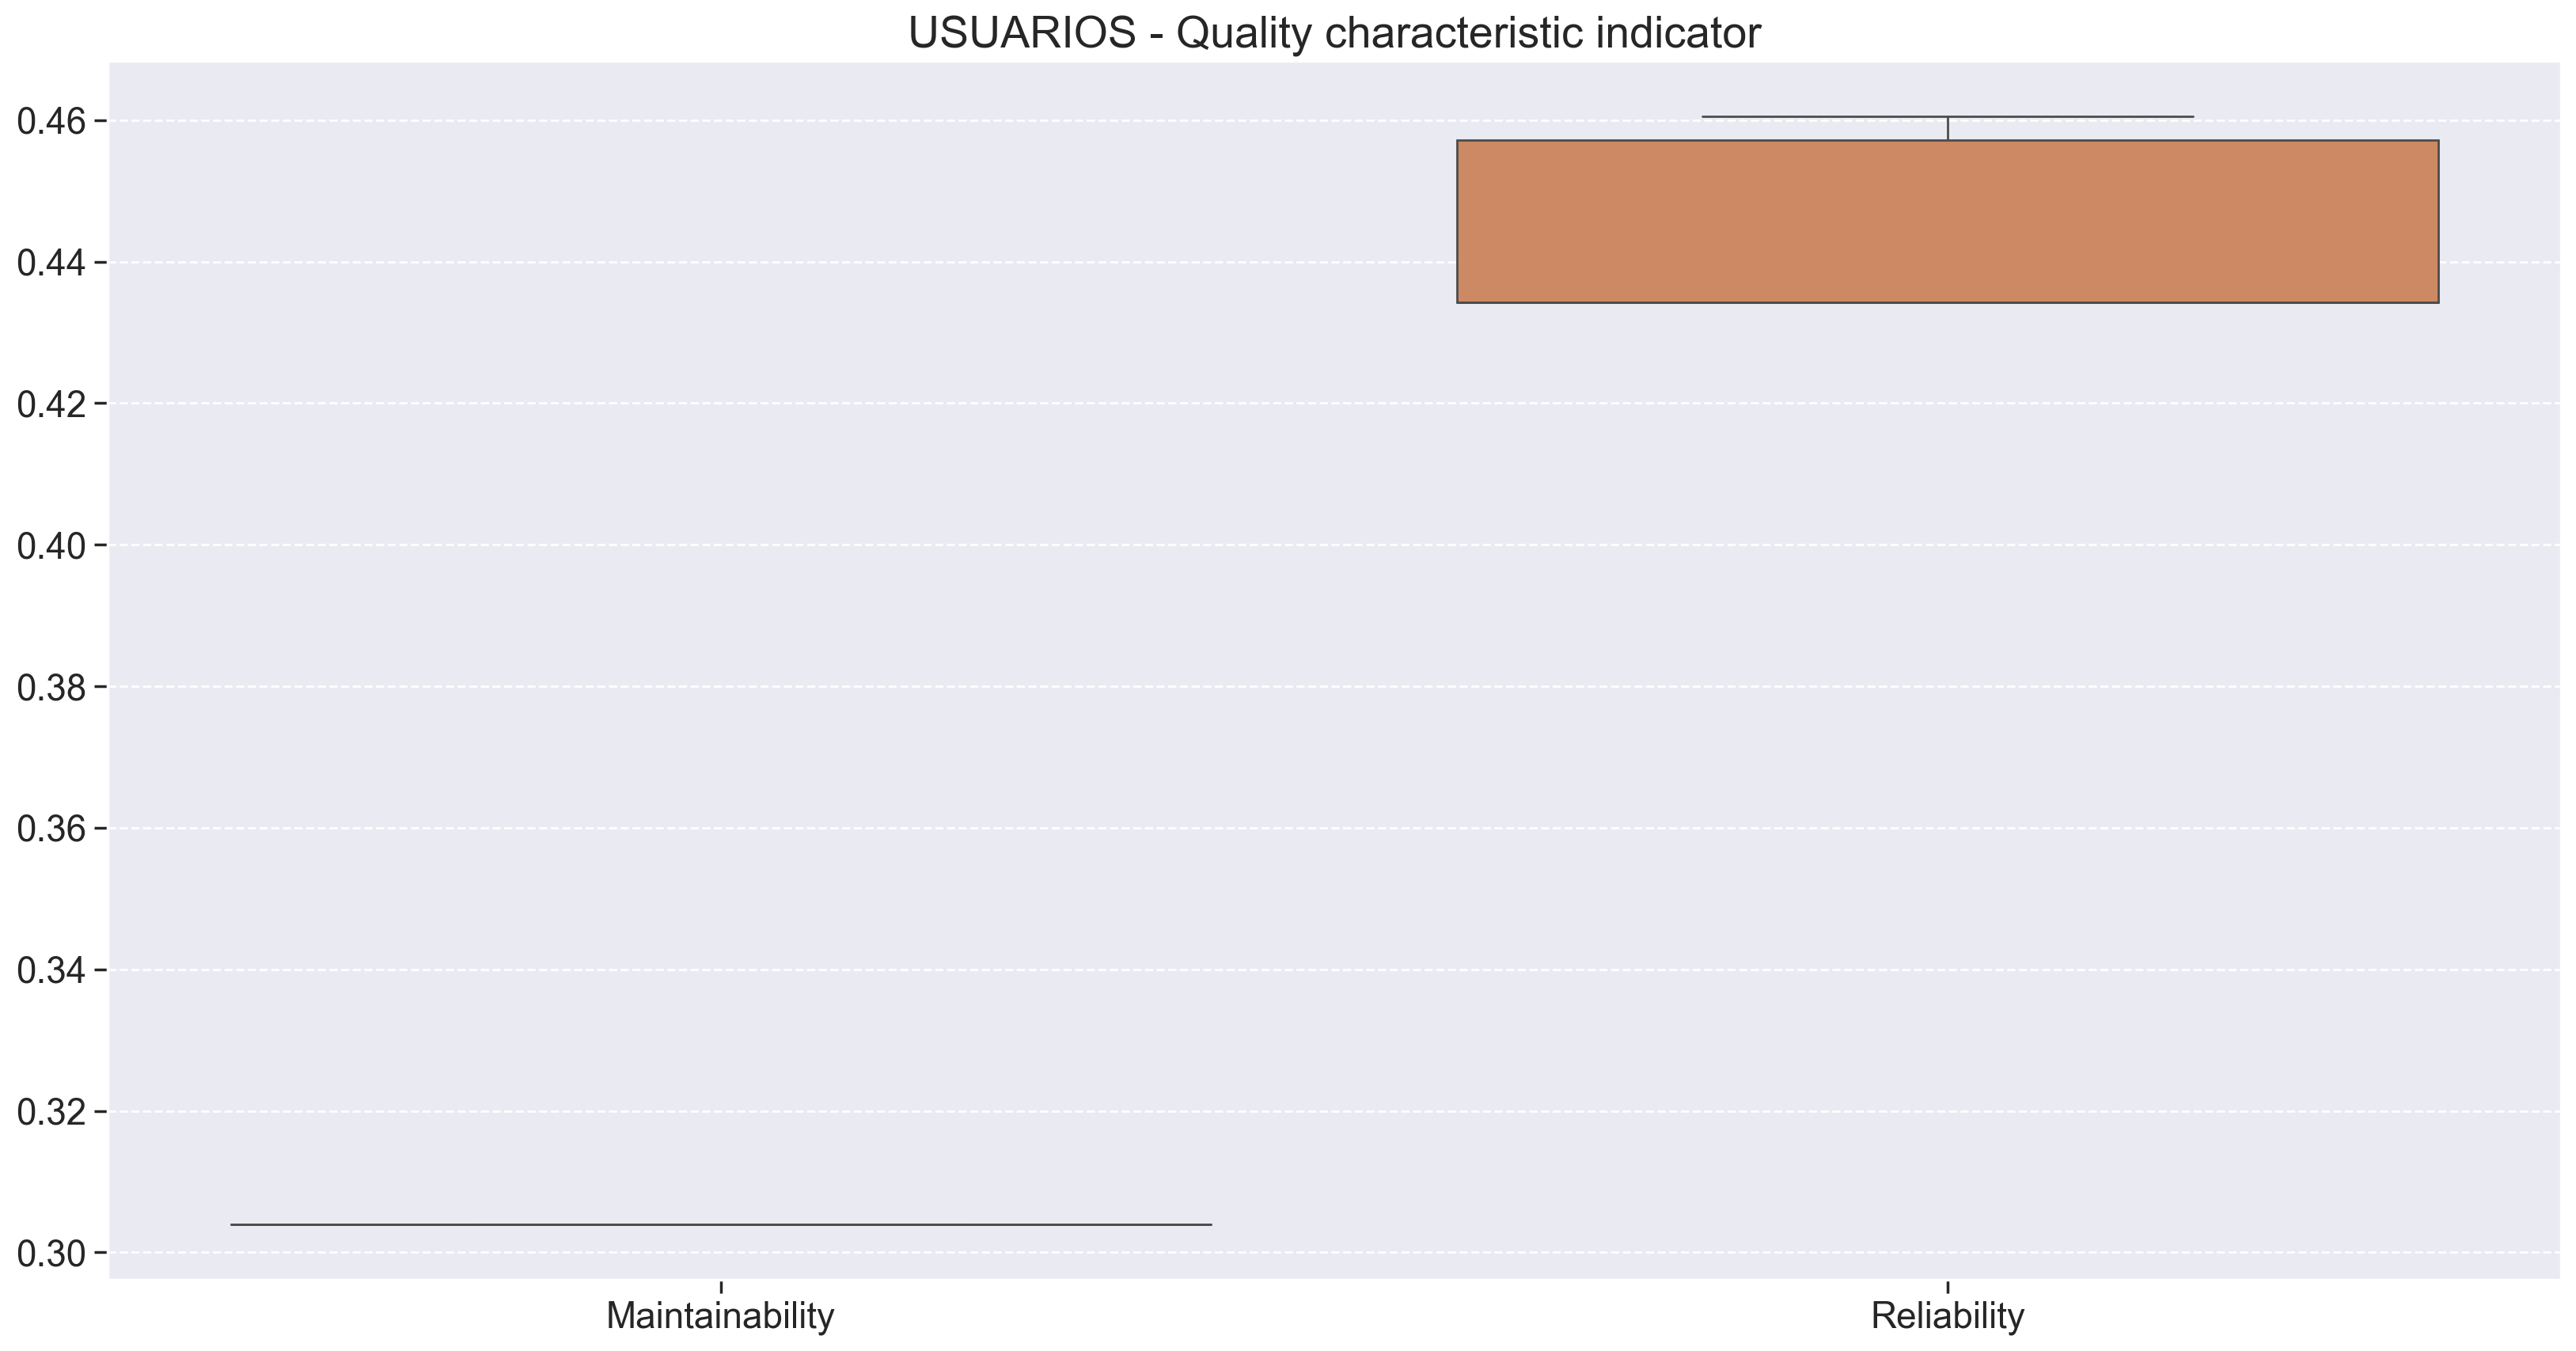

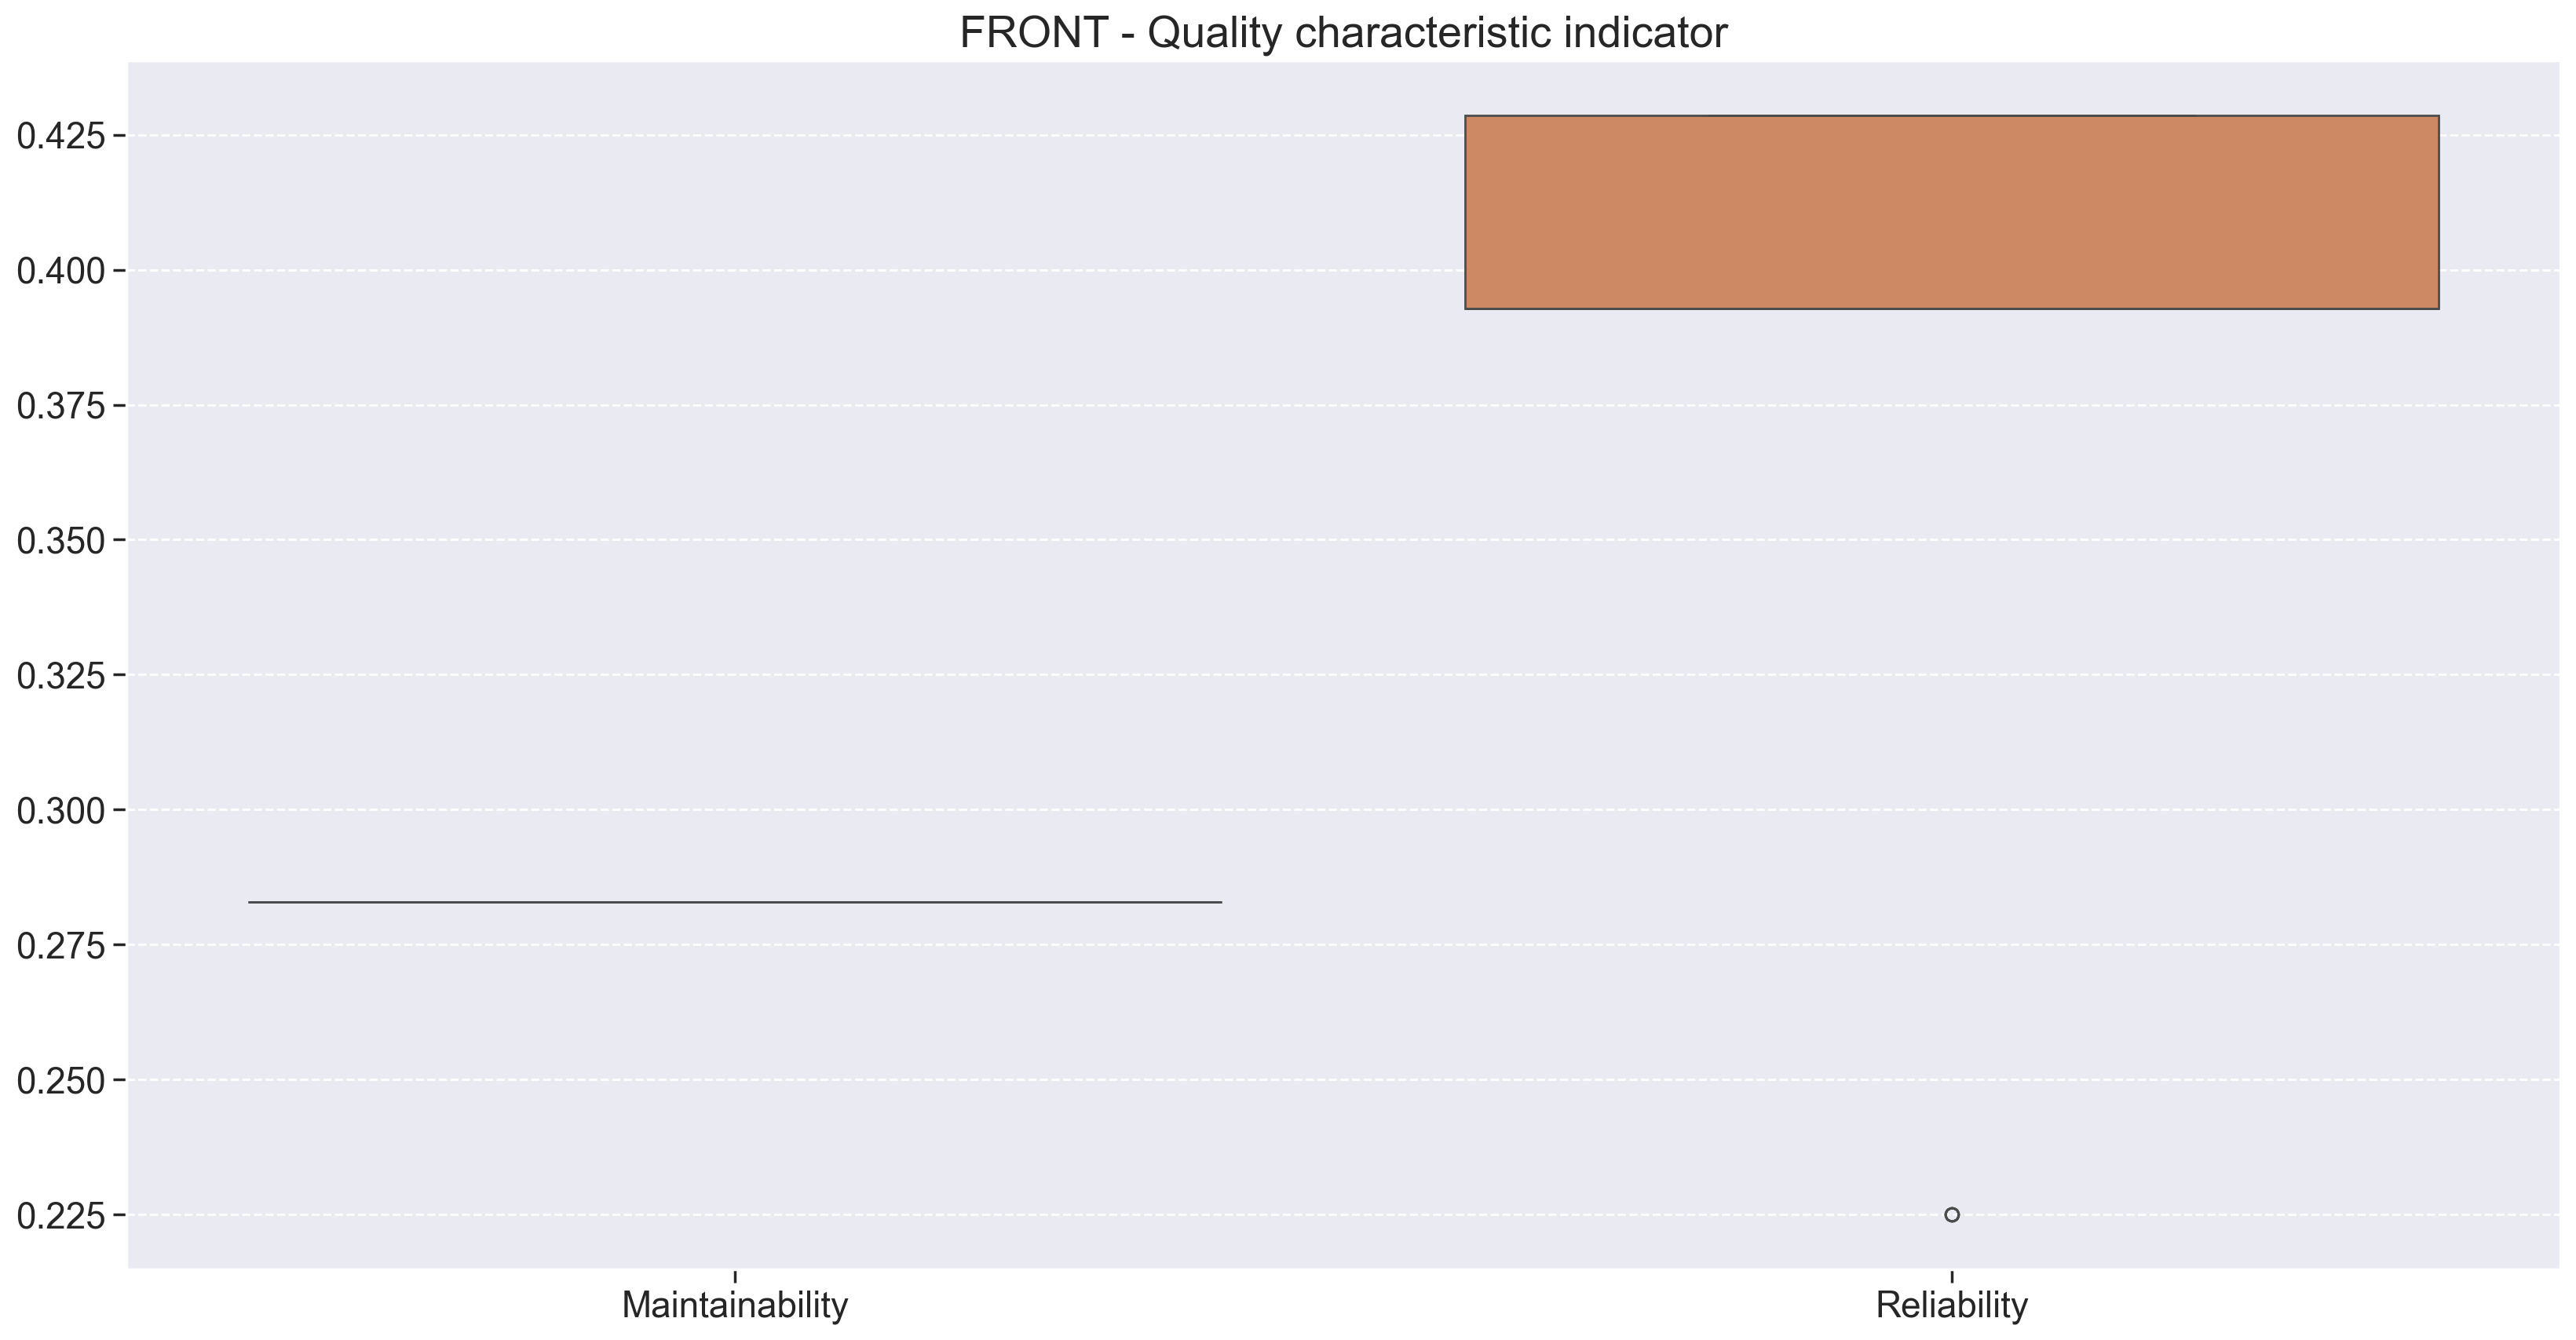

In [224]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

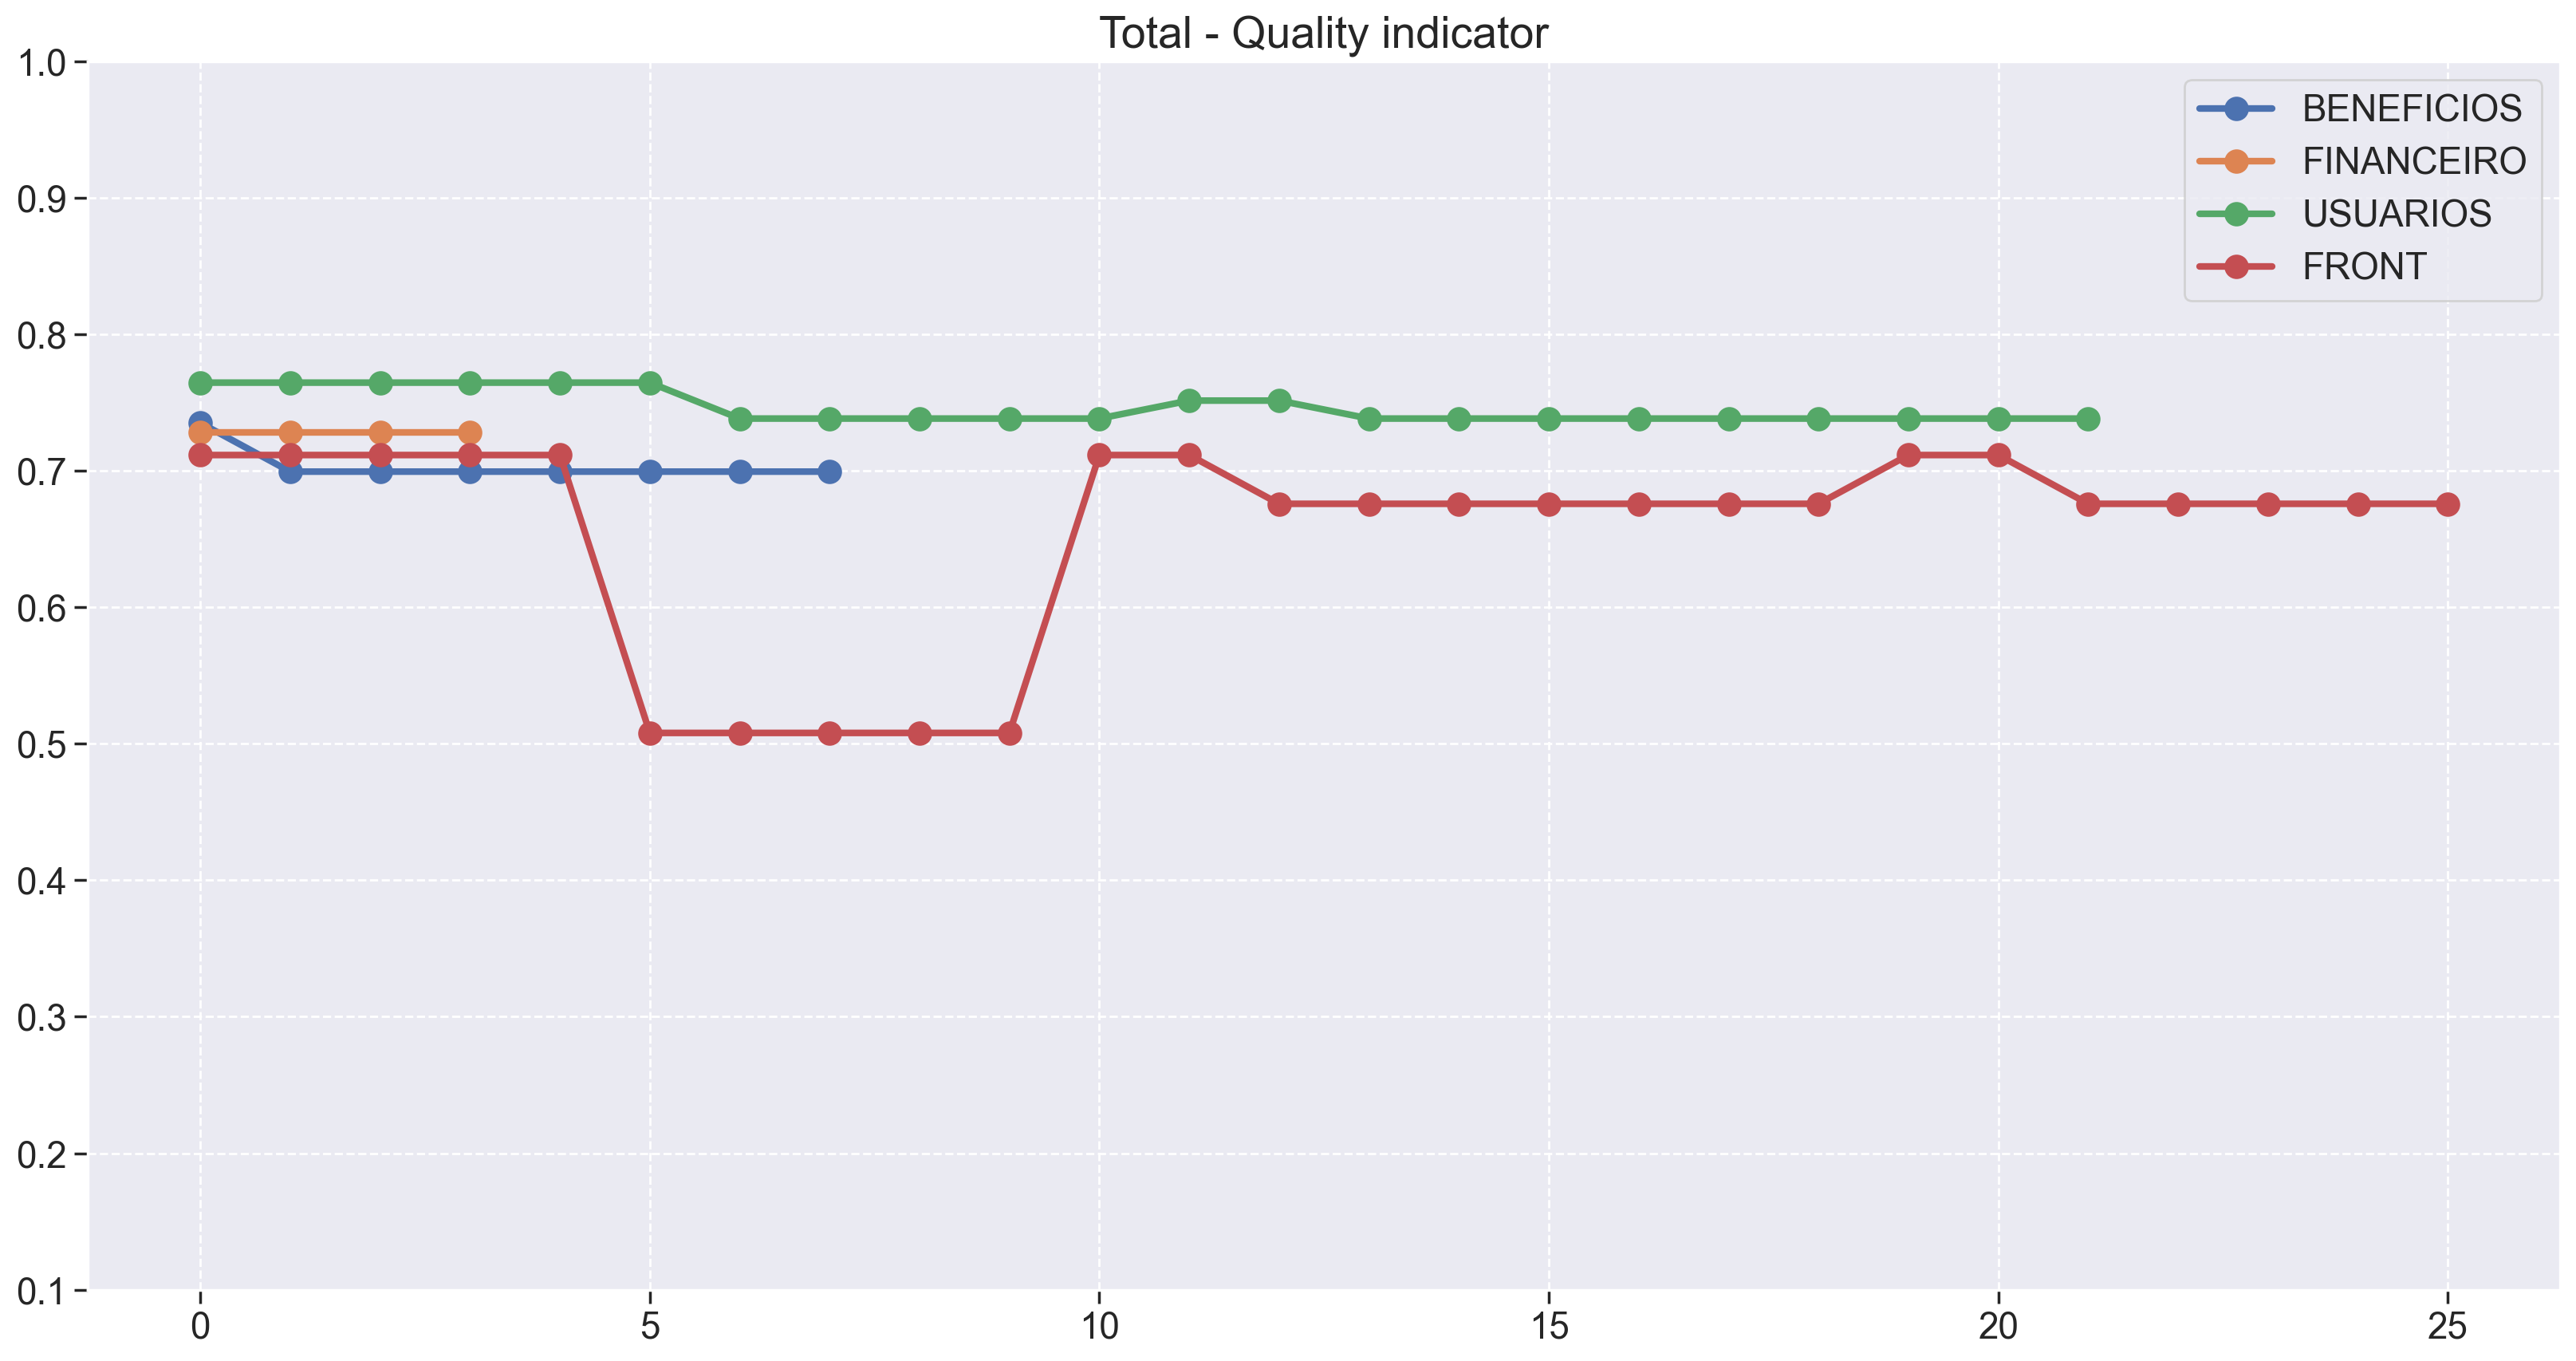

In [225]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [226]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2024.2-SENTINELA--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2024.2-SENTINELA--{}.csv'.format(current_datetime), index = False)

,complexity,comments,duplication,test_success,fast_tests,coverage,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.571429,0.285714,1.000000,1.0,1.0,0.714286,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,1-16-2025-2-42-51,742,0.612857,0.857143,0.306429,0.428571,0.735000
1,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-13-2024-13-54-25,742,0.612857,0.785714,0.306429,0.392857,0.699286
2,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-13-39-38,742,0.612857,0.785714,0.306429,0.392857,0.699286
3,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-13-41-38,742,0.612857,0.785714,0.306429,0.392857,0.699286
4,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-3-44-34,742,0.612857,0.785714,0.306429,0.392857,0.699286
5,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-3-44-37,742,0.612857,0.785714,0.306429,0.392857,0.699286
6,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-7-2024-1-8-18,742,0.612857,0.785714,0.306429,0.392857,0.699286
7,0.571429,0.285714,1.000000,1.0,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-7-2024-1-8-4,742,0.612857,0.785714,0.306429,0.392857,0.699286
8,0.538462,0.076923,1.000000,1.0,1.0,0.846154,fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO,12-13-2024-13-48-6,3196,0.533077,0.923077,0.266538,0.461538,0.728077
9,0.538462,0.076923,1.000000,1.0,1.0,0.846154,fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO,12-17-2024-3-43-48,3196,0.533077,0.923077,0.266538,0.461538,0.728077
